# Installs

In [ ]:
#@title Opt 1
%%capture

!pip install -q pytorch-lightning
!pip install -q wandb

In [ ]:
#@title Opt 2
%%capture
import torch

if torch.cuda.is_available():
    !pip install -q faiss-gpu
else:
    !pip install -q faiss-cpu

# Imports

## Core

In [ ]:
NB_ENV = 'colab'
# NB_ENV = 'kaggle'

assert NB_ENV in ['colab', 'kaggle']

In [ ]:
import torch.multiprocessing as mp

# Set the start method to 'spawn' before importing any libraries
mp.set_start_method('spawn', force=True)

In [ ]:
import os
import glob
import copy

import math
import numpy as np
from numpy import ma
import pandas as pd

from sklearn.preprocessing import LabelEncoder

# import torchvision as tv
from torchvision.datasets import CelebA
import torchvision.transforms.v2 as transforms

import torch
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Sequential, Module
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
import torch.nn.functional as F

from tqdm.notebook import tqdm

GLOBAL_SEED = 2024

In [ ]:
# Default
ROOT_SAVE_DIR = '.'
ROOT_WORK_DIR = '.'

# Optionally load from GDrive
# ROOT_SAVE_DIR = '/content/drive/MyDrive/practice/face-recognition'

## Optional #1

In [ ]:
import torchmetrics
from torchmetrics import Accuracy
from torchmetrics.classification import BinaryROC

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

from torch import optim
from itertools import chain
from torch.optim.lr_scheduler import MultiStepLR
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


import wandb

pl.seed_everything(GLOBAL_SEED)

INFO:lightning_fabric.utilities.seed:Seed set to 2024


2024

# Datasets

## Common functions

In [ ]:
#@title Dataloaders getter
def get_dataloaders(ds_train=None, ds_valid=None, ds_test=None, batch_size=64):
    assert ds_train is not None \
        or ds_valid is not None \
        or ds_test is not None

    dataloaders = []
    if ds_train is not None:
        dl_train = DataLoader(ds_train, batch_size, shuffle=True)
        dataloaders.append(dl_train)

    if ds_valid is not None:
        dl_valid = DataLoader(ds_valid, batch_size, shuffle=False)
        dataloaders.append(dl_valid)

    if ds_test is not None:
        dl_test = DataLoader(ds_test, batch_size, shuffle=False)
        dataloaders.append(dl_test)

    if len(dataloaders) == 1:
        return dataloaders[0]
    else:
        return dataloaders

In [ ]:
#@title Show imgs function
# TODO: show class labels

import numpy as np
import math
from IPython.display import clear_output
import matplotlib.pyplot as plt


def show_images(imgs: torch.tensor, imgs_paired: torch.tensor = None, title=None,
                vertical=False, gray_cmap=False, imgs_titles=None,
                max_rows: int = 5, max_cols: int = 5,
                inv_normalize=None
                ):

    clear_output(wait=True)
    if gray_cmap:
        cmap = 'gray'
    else:
        cmap = None

    if inv_normalize is not None:
        imgs = inv_normalize(imgs)

    # Convert float tensor of range [0.0, 255.0] to int
    imgs = imgs.int()
    if imgs_paired is not None:
        imgs_paired = imgs_paired.int()

    imgs = imgs.detach().cpu().permute(0, 2, 3, 1)
    if imgs_paired is not None:
        imgs_paired = imgs_paired.detach().cpu().permute(0, 2, 3, 1)
        if inv_normalize is not None:
            imgs_paired = inv_normalize(imgs_paired)

    if vertical:
        nrows = min(imgs.shape[0], max_rows)
        ncols = 1
        if imgs_paired is not None:
            nrows = min(nrows, imgs_paired.shape[0])
            ncols = 2
        fig = plt.figure(figsize=(2*ncols, 2*nrows))

        for i, img in enumerate(imgs[:nrows]):
            idx = 2*i+1 if imgs_paired is not None else i+1
            plt.subplot(nrows, ncols, idx)
            plt.imshow(img, cmap=cmap)

        if imgs_paired is not None:
            for i, img_paired in enumerate(imgs_paired[:nrows]):
                plt.subplot(nrows, ncols, 2*i+2)
                plt.imshow(img_paired, cmap=cmap)
    else:
        ncols = min(imgs.shape[0], max_cols)
        nrows = 2 if imgs_paired is not None else 1

        fig = plt.figure(figsize=(16, 5))

        for i, img in enumerate(imgs[:ncols]):
            plt.subplot(nrows, ncols, i+1)
            plt.imshow(img, cmap=cmap)

        if imgs_paired is not None:
            for i, img_paired in enumerate(imgs_paired[:ncols]):
                plt.subplot(nrows, ncols, ncols+i+1)
                plt.imshow(img_paired, cmap=cmap)

    if title is not None:
        plt.suptitle(title, size=25)

    axes = plt.gcf().get_axes()
    if imgs_titles is not None:
        for ax, img_title in zip(axes, imgs_titles):
            ax.set_title(img_title)
            ax.set_axis_off()
    else:
        for ax in axes:
            ax.set_axis_off()

    fig.tight_layout()
    plt.show()

def show_image_grid(imgs, imgs_titles=None, max_cols=5, title=None, gray_cmap=False,
                    inv_normalize=None):
    max_imgs_per_row = math.ceil(math.sqrt(imgs.shape[0]))
    ncols = min(max_imgs_per_row, max_cols)
    nrows = ncols

    if gray_cmap:
        cmap = 'gray'
    else:
        cmap = None

    if inv_normalize is not None:
        imgs = inv_normalize(imgs)

    if imgs.max() > 1 or imgs.min() < 0:
        imgs = imgs / 255

    fig = plt.figure(figsize=(ncols*4, nrows*4))
    imgs = imgs.detach().cpu().permute(0, 2, 3, 1)
    for i, img in enumerate(imgs[:ncols**2]):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img, cmap=cmap)

    axes = plt.gcf().get_axes()
    if imgs_titles is not None:
        for ax, img_title in zip(axes, imgs_titles):
            ax.set_title(img_title)
            ax.set_axis_off()
    else:
        for ax in axes:
            ax.set_axis_off()

    if title is not None:
        plt.suptitle(title, size=20)

    fig.tight_layout()
    plt.show()

## Dataset: CelebA500 (train/val/test splits)

### Transforms

In [ ]:
from PIL import Image

class CustomCrop(object):
    def __init__(self, top, bottom, left, right):
        self.top = top
        self.bottom = bottom
        self.left = left
        self.right = right

    def __call__(self, img):
        img = img[:, self.top:self.bottom, self.left:self.right]
        return img

# square crop
square_crop = [
    CustomCrop(77, -41, 37, -41)
]

In [ ]:
CROP_TRANSFORM = square_crop
RESCALE_SIZE = 112

MEAN = np.array([127.5, 127.5, 127.5])
STD = np.array([128, 128, 128])

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    # transforms.RandomPhotometricDistort(),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=False),
    *CROP_TRANSFORM,
    transforms.Resize((RESCALE_SIZE, RESCALE_SIZE), antialias=False),
    transforms.Normalize(MEAN, STD)
])

transform_test = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=False),
    *CROP_TRANSFORM,
    transforms.Resize((RESCALE_SIZE, RESCALE_SIZE), antialias=False),
    transforms.Normalize(MEAN, STD)
])

inv_normalize = transforms.Normalize(
    mean = -MEAN / STD,
    std = 1 / STD
)

### Download data

In [ ]:
if NB_ENV == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    ROOT_SAVE_DIR = '/content/drive/MyDrive/practice/DSL1-project-face-recognition'
    ROOT_WORK_DIR = '.'
    ROOT_DATA_DIR = os.path.join(ROOT_WORK_DIR, 'data')

    TRAIN_ZIP_PATH = os.path.join(ROOT_SAVE_DIR, 'celebA_train_500.zip')

    !unzip -qn {TRAIN_ZIP_PATH} -d {ROOT_DATA_DIR}

    CELEBA_DATA_DIR = os.path.join(ROOT_DATA_DIR, 'celebA_train_500')

Mounted at /content/drive


In [ ]:
if NB_ENV == 'kaggle':
    # ROOT_SAVE_DIR = '/kaggle/input/'
    ROOT_WORK_DIR = '/kaggle/input/'
    ROOT_DATA_DIR = os.path.join(ROOT_WORK_DIR, 'celeba-500')

    IR_ZIP_PATH = os.path.join(ROOT_SAVE_DIR, 'celebA_ir.zip')
    TRAIN_ZIP_PATH = os.path.join(ROOT_SAVE_DIR, 'celebA_train_500.zip')

    CELEBA_DATA_DIR = os.path.join(ROOT_DATA_DIR, 'celebA_train_500', 'celebA_train_500')
    CELEBA_IR_DIR = os.path.join(ROOT_DATA_DIR, 'celebA_ir', 'celebA_ir')

### Read metadata

In [ ]:
root_dir = CELEBA_DATA_DIR

split_file = os.path.join(root_dir, 'celebA_train_split.txt')
split_df = pd.read_csv(split_file, delimiter=' ', header=None)
split_df = split_df.rename(mapper={0: 'filename', 1: 'split_id'}, axis=1)
split_df.head()

,filename,split_id
0,000001.jpg,0
1,000404.jpg,0
2,003415.jpg,0
3,004390.jpg,0
4,018062.jpg,0


In [ ]:
split = 'train'

split_to_split_id = {
    'train': 0,
    'valid': 1,
    'test': 2
}

split_id = split_to_split_id[split]
split_df = split_df.groupby('split_id').get_group(split_id).reset_index(drop=True)
split_df

,filename,split_id
0,000001.jpg,0
1,000404.jpg,0
2,003415.jpg,0
3,004390.jpg,0
4,018062.jpg,0
...,...,...
8539,082211.jpg,0
8540,084342.jpg,0
8541,087286.jpg,0
8542,089001.jpg,0


In [ ]:
anno_file = os.path.join(root_dir, 'celebA_anno.txt')
anno_df = pd.read_csv(anno_file, delimiter=' ', header=None)
anno_df = anno_df.rename(mapper={0: 'filename', 1: 'id'}, axis=1)
anno_df.head()

,filename,id
0,000001.jpg,0
1,000404.jpg,0
2,003415.jpg,0
3,004390.jpg,0
4,018062.jpg,0


In [ ]:
metadata_df = split_df.merge(anno_df, on='filename')
metadata_df.head()

,filename,split_id,id
0,000001.jpg,0,0
1,000404.jpg,0,0
2,003415.jpg,0,0
3,004390.jpg,0,0
4,018062.jpg,0,0


### Dataset

In [ ]:
#@title CelebA500Dataset
import pandas as pd
from PIL import Image

class CelebA500Dataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            annotation_file (string): Path to the CSV file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """

        self.imgs_dir = os.path.join(root_dir, 'celebA_imgs')
        self.transform = transform

        split_file = os.path.join(root_dir, 'celebA_train_split.txt')
        split_df = pd.read_csv(split_file, delimiter=' ', header=None)
        split_df = split_df.rename(mapper={0: 'filename', 1: 'split_id'}, axis=1)

        split_name_to_id = {
            'train': 0,
            'valid': 1,
            'test': 2
        }

        split_id = split_name_to_id[split]
        split_df = split_df.groupby('split_id').get_group(split_id).reset_index(drop=True)

        anno_file = os.path.join(root_dir, 'celebA_anno.txt')
        anno_df = pd.read_csv(anno_file, delimiter=' ', header=None)
        anno_df = anno_df.rename(mapper={0: 'filename', 1: 'id'}, axis=1)

        metadata_df = split_df.merge(anno_df, on='filename')
        self.image_filename = metadata_df['filename'].to_list()
        self.identity = torch.tensor(metadata_df['id'].to_numpy())

    def __len__(self):
        return len(self.identity)

    def __getitem__(self, idx):
        img_filepath = os.path.join(self.imgs_dir, self.image_filename[idx])
        image = Image.open(img_filepath)
        if self.transform:
            image = self.transform(image)

        identity = self.identity[idx]

        return image, identity

In [ ]:
ds_train = CelebA500Dataset(CELEBA_DATA_DIR, split='train', transform=transform_train)
ds_valid = CelebA500Dataset(CELEBA_DATA_DIR, split='valid', transform=transform_test)
ds_test = CelebA500Dataset(CELEBA_DATA_DIR, split='test', transform=transform_test)

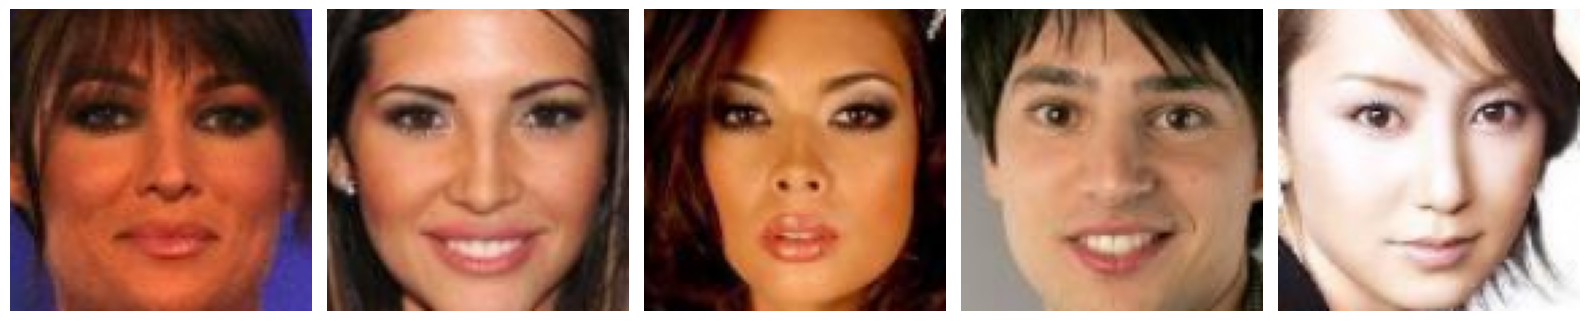

In [ ]:
dl_train, _, _ = get_dataloaders(ds_train, ds_valid, ds_test, 5)

sample_images, _ = next(iter(dl_train))
show_images(sample_images, inv_normalize=inv_normalize)

## Dataset: CelebA500 (IR split)

### Download

In [ ]:
if NB_ENV == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    ROOT_SAVE_DIR = '/content/drive/MyDrive/practice/DSL1-project-face-recognition'
    ROOT_WORK_DIR = '.'
    ROOT_DATA_DIR = os.path.join(ROOT_WORK_DIR, 'data')

    IR_ZIP_PATH = os.path.join(ROOT_SAVE_DIR, 'celebA_ir.zip')
    !unzip -qn {IR_ZIP_PATH} -d {ROOT_DATA_DIR}

    CELEBA_IR_DIR = os.path.join(ROOT_DATA_DIR, 'celebA_ir')

Mounted at /content/drive


In [ ]:
if NB_ENV == 'kaggle':
    # ROOT_SAVE_DIR = '/kaggle/input/'
    ROOT_WORK_DIR = '/kaggle/input/'
    ROOT_DATA_DIR = os.path.join(ROOT_WORK_DIR, 'celeba-500')

    IR_ZIP_PATH = os.path.join(ROOT_SAVE_DIR, 'celebA_ir.zip')
    CELEBA_IR_DIR = os.path.join(ROOT_DATA_DIR, 'celebA_ir', 'celebA_ir')

In [ ]:
!ls {CELEBA_IR_DIR}

celebA_anno_query.csv  celebA_distractors  celebA_query


### Read metadata & prepare dataset

In [ ]:
file_path = os.path.join(CELEBA_IR_DIR, 'celebA_anno_query.csv')
anno_df = pd.read_csv(file_path)
anno_df.head()

,img,id
0,001265.jpg,35
1,001430.jpg,35
2,012834.jpg,35
3,041171.jpg,35
4,041823.jpg,35


In [ ]:
imgs_dir = os.path.join(CELEBA_IR_DIR, 'celebA_distractors')
image_filenames = os.listdir(imgs_dir)
id_to_idx = {id: df['img'].index.to_list() for id, df in anno_df.groupby('id')}

In [ ]:
import pandas as pd
from PIL import Image

class CelebA500DatasetIR(Dataset):
    def __init__(self, root_dir, split='query', transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
        """
        assert split in ['query', 'distractors']

        self.transform = transform

        if split == 'query':
            self.imgs_dir = os.path.join(root_dir, 'celebA_query')

            file_path = os.path.join(root_dir, 'celebA_anno_query.csv')
            anno_df = pd.read_csv(file_path)

            self.image_filenames = anno_df['img'].to_list()
            self.labels = torch.tensor(anno_df['id'].to_numpy())
            self.id_to_idx = {id: df['img'].index.to_list() for id, df in anno_df.groupby('id')}

        elif split == 'distractors':
            self.imgs_dir = os.path.join(root_dir, 'celebA_distractors')

            self.image_filenames = os.listdir(imgs_dir)
            self.labels = torch.full((len(image_filenames),), np.nan) # distractors' ids are unknown

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_filepath = os.path.join(self.imgs_dir, self.image_filenames[idx])
        image = Image.open(img_filepath)
        if self.transform is not None:
            image = self.transform(image)

        label = self.labels[idx]

        return image, label

In [ ]:
class SquarePad(object):
	def __call__(self, image):
		h, w = image.size(-2), image.size(-1)
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return transforms.functional.pad(image, padding, 0, 'constant')

In [ ]:
RESCALE_SIZE = 112

MEAN = np.array([127.5, 127.5, 127.5])
STD = np.array([128, 128, 128])

transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=False),
    SquarePad(),
    transforms.Resize((RESCALE_SIZE, RESCALE_SIZE), antialias=False),
    transforms.Normalize(MEAN, STD)
])

inv_normalize = transforms.Normalize(
    mean = -MEAN / STD,
    std = 1 / STD
)

In [ ]:
def get_datasets_celeba_500_ir():
    ds_query = CelebA500DatasetIR(CELEBA_IR_DIR, 'query', transform=transform)
    ds_distr = CelebA500DatasetIR(CELEBA_IR_DIR, 'distractors', transform=transform)
    return ds_query, ds_distr

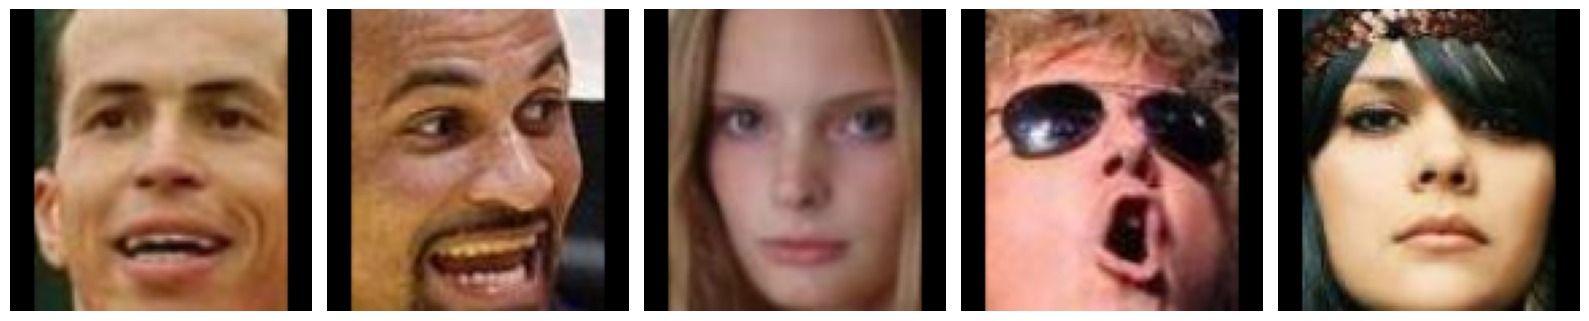

In [ ]:
ds_query, ds_distr = get_datasets_celeba_500_ir()
dl_query, dl_distr = get_dataloaders(None, ds_query, ds_distr, 5)

sample_images, _ = next(iter(dl_distr))
show_images(sample_images, inv_normalize=inv_normalize)

## Dataset: UMDFaces (Aligned 112x112)

### Download

In [ ]:
# Download to ROOT_SAVE_DIR
# https://github.com/ZhaoJ9014/face.evoLVe?tab=readme-ov-file#data-zoo

if NB_ENV == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    ROOT_SAVE_DIR = '/content/drive/MyDrive/practice/DSL1-project-face-recognition'
    ROOT_WORK_DIR = '.'

    ROOT_DATA_DIR = os.path.join(ROOT_WORK_DIR, 'data')

    zip_path = os.path.join(ROOT_SAVE_DIR, 'Umdfaces.zip')
    !unzip -nq {zip_path} -d {ROOT_DATA_DIR}

Mounted at /content/drive


In [ ]:
if NB_ENV == 'kaggle':
    ROOT_SAVE_DIR = '/kaggle/input/'
    ROOT_WORK_DIR = '/kaggle/input/'

    ROOT_DATA_DIR = os.path.join(ROOT_WORK_DIR, 'umdfaces-dataset')

In [ ]:
UMD_DATA_DIR = os.path.join(ROOT_DATA_DIR, 'images')
UMD_DATA_DIR

'./data/images'

### Step-by-step

In [ ]:
root_dir = UMD_DATA_DIR

image_paths = []
labels = []

limit_cnt = 30
for idx, label in enumerate(tqdm(os.listdir(root_dir))):
    if NB_ENV == 'kaggle' and (idx + 1) % limit_cnt == 0: # performance hack
        break

    label_path = os.path.join(root_dir, label)
    if os.path.isdir(label_path):
        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)
            image_paths.append(img_path)
            labels.append(int(label))

  0%|          | 0/8277 [00:00<?, ?it/s]

In [ ]:
len(labels)

367888

In [ ]:
metadata_df_all = pd.DataFrame({'id': labels, 'image_path': image_paths})
metadata_df_all

,id,image_path
0,6812,./data/images/6812/00316901.jpg
1,6812,./data/images/6812/00316877.jpg
2,6812,./data/images/6812/00316892.jpg
3,6812,./data/images/6812/00316870.jpg
4,6812,./data/images/6812/00316894.jpg
...,...,...
367883,6586,./data/images/6586/00308474.jpg
367884,6586,./data/images/6586/00308466.jpg
367885,6586,./data/images/6586/00308476.jpg
367886,6586,./data/images/6586/00308470.jpg


In [ ]:
# Limit number of images by fraction of used ids

np.random.seed(GLOBAL_SEED)

limit_labels = 0.1
num_labels_to_include = int(limit_labels * metadata_df_all['id'].nunique())
labels_to_include = np.random.choice(metadata_df_all['id'], num_labels_to_include)
metadata_df = metadata_df_all[metadata_df_all['id'].isin(labels_to_include)].reset_index(drop=True)

print(f"Used labels: {metadata_df['id'].nunique()}/{metadata_df_all['id'].nunique()}")
print(f"Used images: {metadata_df.shape[0]}/{metadata_df_all.shape[0]}")

Used labels: 784/8277
Used images: 43701/367888


In [ ]:
# Label encode new set of labels
le = LabelEncoder()
metadata_df['id'] = le.fit_transform(metadata_df['id'])
metadata_df['id'].min(), metadata_df['id'].max()

(0, 783)

In [ ]:
# Make sure every person has at least 3 imgs
(metadata_df.groupby('id').size() > 3).sum() == metadata_df['id'].nunique()

True

In [ ]:
# Guarantee one image per each person for each split
guaranteed_imgs = metadata_df.groupby('id').sample(3, random_state=GLOBAL_SEED)
guaranteed_imgs.head(9)

,id,image_path
31463,0,./data/images/3/00000124.jpg
31442,0,./data/images/3/00000128.jpg
31468,0,./data/images/3/00000138.jpg
12778,1,./data/images/6/00000270.jpg
12759,1,./data/images/6/00000264.jpg
12760,1,./data/images/6/00000263.jpg
7061,2,./data/images/18/00000811.jpg
7067,2,./data/images/18/00000808.jpg
7080,2,./data/images/18/00000787.jpg


In [ ]:
# Guarantee one image per each person for each split
imgs_cnt = len(guaranteed_imgs.index)

train_idx = guaranteed_imgs.iloc[np.arange(0, imgs_cnt, 1)].index
valid_idx = guaranteed_imgs.iloc[np.arange(1, imgs_cnt-1, 1)].index
test_idx = guaranteed_imgs.iloc[np.arange(2, imgs_cnt-2, 1)].index

In [ ]:
from sklearn.model_selection import train_test_split

def stratified_split_indices(indices, stratify, random_state,
                             train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1):

    assert train_ratio + valid_ratio + test_ratio == 1

    temp_idx, test_idx = train_test_split(
        indices,
        test_size=test_ratio,
        stratify=stratify.iloc[indices],
        random_state=random_state
    )

    valid_ratio_temp = valid_ratio / (train_ratio + valid_ratio)

    train_idx, valid_idx = train_test_split(
        temp_idx,
        test_size=valid_ratio_temp,
        stratify=stratify.iloc[temp_idx],
        random_state=random_state
    )

    return train_idx, valid_idx, test_idx

In [ ]:
# Split remaining images in a stratified manner
guaranteed_idx = np.concatenate([train_idx, valid_idx, test_idx])
remain_idx = metadata_df.iloc[metadata_df.index.difference(guaranteed_idx)].index

train_remain_idx, valid_remain_idx, test_remain_idx = stratified_split_indices(
    indices=remain_idx,
    stratify=metadata_df['id'],
    random_state=GLOBAL_SEED
)

In [ ]:
# Check image count per person for each split
ids_tr = metadata_df.iloc[train_remain_idx]['id'].unique()
ids_va = metadata_df.iloc[valid_remain_idx]['id'].unique()
ids_te = metadata_df.iloc[test_remain_idx]['id'].unique()

# Val and test splits might not have at least one image per each person, but train does
len(set(ids_tr) - set(ids_te)), len(set(ids_tr) - set(ids_va)), len(set(ids_va) - set(ids_tr))

(0, 0, 0)

In [ ]:
# get final indices lists for each split
train_idx = train_idx.union(train_remain_idx)
valid_idx = valid_idx.union(valid_remain_idx)
test_idx = test_idx.union(test_remain_idx)

In [ ]:
metadata_df.iloc[train_idx]['image_path'].to_list()[:5]

['./data/images/2819/00132114.jpg',
 './data/images/2819/00132095.jpg',
 './data/images/2819/00132080.jpg',
 './data/images/2819/00132073.jpg',
 './data/images/2819/00132092.jpg']

In [ ]:
for id, idx in metadata_df.groupby('id'):
    print(id)
    display(idx['image_path'].to_list()[:10])
    break

0


['./data/images/3/00000142.jpg',
 './data/images/3/00000132.jpg',
 './data/images/3/00000136.jpg',
 './data/images/3/00000153.jpg',
 './data/images/3/00000134.jpg',
 './data/images/3/00000146.jpg',
 './data/images/3/00000126.jpg',
 './data/images/3/00000148.jpg',
 './data/images/3/00000147.jpg',
 './data/images/3/00000154.jpg']

In [ ]:
metadata_df.iloc[train_idx].shape[0]

35431

In [ ]:
# Map each id to indices of images
id_to_idx = {id: idx['image_path'].index.to_list() for id, idx in metadata_df.groupby('id')}
id_to_idx[list(id_to_idx.keys())[0]][:10]

[31426, 31427, 31428, 31429, 31430, 31431, 31432, 31433, 31434, 31435]

### Functions

In [ ]:
#@title FaceDataset
from PIL import Image
from sklearn.preprocessing import LabelEncoder

class FaceDataset(Dataset):
    def __init__(self, root_dir, split, transform=None,
                 limit_labels=None, limit_images=None, seed=GLOBAL_SEED):
        assert split in ['train', 'valid', 'test']

        if limit_labels is not None:
            assert limit_images is None
        elif limit_images is not None:
            assert limit_labels is None
            raise NotImplementedError

        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.limit_labels = limit_labels
        self.seed = seed

        self.image_paths = None
        self.labels = None

        # Load image paths and labels
        self._load_data()

    def _load_data(self):
        np.random.seed(self.seed)

        image_paths = []
        labels = []

        for label in os.listdir(self.root_dir):
            label_path = os.path.join(self.root_dir, label)
            if os.path.isdir(label_path):
                for img_name in os.listdir(label_path):
                    img_path = os.path.join(label_path, img_name)
                    image_paths.append(img_path)
                    labels.append(int(label))

        metadata_df_all = pd.DataFrame({'id': labels, 'image_path': image_paths})

        # Limit number of used images by fraction of used labels
        if self.limit_labels is not None:
            num_labels_to_include = int(self.limit_labels * metadata_df_all['id'].nunique())
            labels_to_include = np.random.choice(metadata_df_all['id'], num_labels_to_include)
            metadata_df = metadata_df_all[metadata_df_all['id'].isin(labels_to_include)] \
                .reset_index(drop=True)
        else:
            metadata_df = metadata_df_all

        print(f"Used labels: {metadata_df['id'].nunique()}/{metadata_df_all['id'].nunique()}")
        print(f"Used images: {metadata_df.shape[0]}/{metadata_df_all.shape[0]}")
        print()

        self.num_classes = metadata_df['id'].nunique()

        # Label encode new set of labels
        le = LabelEncoder()
        metadata_df['id'] = le.fit_transform(metadata_df['id'])
        metadata_df['id'].min(), metadata_df['id'].max()

        # Guarantee one image per each person for each split
        guaranteed_imgs = metadata_df.groupby('id').sample(3, random_state=self.seed)

        # Guarantee one image per each person for each split
        imgs_cnt = len(guaranteed_imgs.index)
        train_idx = guaranteed_imgs.iloc[np.arange(0, imgs_cnt, 1)].index
        valid_idx = guaranteed_imgs.iloc[np.arange(1, imgs_cnt-1, 1)].index
        test_idx = guaranteed_imgs.iloc[np.arange(2, imgs_cnt-2, 1)].index

        # Split remaining images in a stratified manner
        guaranteed_idx = np.concatenate([train_idx, valid_idx, test_idx])
        remain_idx = metadata_df.iloc[metadata_df.index.difference(guaranteed_idx)].index

        train_remain_idx, valid_remain_idx, test_remain_idx = stratified_split_indices(
            indices=remain_idx,
            stratify=metadata_df['id'],
            random_state=self.seed
        )

        # Get final indices lists for each split
        train_idx = train_idx.union(train_remain_idx)
        valid_idx = valid_idx.union(valid_remain_idx)
        test_idx = test_idx.union(test_remain_idx)

        if self.split == 'train':
            split_idx = train_idx
        elif self.split == 'valid':
            split_idx = valid_idx
        elif self.split == 'test':
            split_idx = test_idx

        metadata_split_df = metadata_df.iloc[split_idx].reset_index(drop=True)

        self.labels = metadata_split_df['id'].to_numpy()
        self.image_paths = metadata_split_df['image_path'].to_numpy()
        self.id_to_idx = {
            id: idx['image_path'].index.to_list()
            for id, idx in metadata_split_df.groupby('id')
            }

        # elif self.split == 'valid':
        #     self.labels = metadata_df.iloc[valid_idx]['id'].to_numpy()
        #     self.image_paths = metadata_df.iloc[valid_idx]['image_path'].to_numpy()
        #     self.id_to_idx = {
        #         id: idx['image_path'].index.to_list()
        #         for id, idx in metadata_df.iloc[valid_idx].groupby('id')
        #         }
        # elif self.split == 'test':
        #     self.labels = metadata_df.iloc[test_idx]['id'].to_numpy()
        #     self.image_paths = metadata_df.iloc[test_idx]['image_path'].to_numpy()
        #     self.id_to_idx = {
        #         id: idx['image_path'].index.to_list()
        #         for id, idx in metadata_df.iloc[test_idx].groupby('id')
        #         }


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
#@title Transforms
RESCALE_SIZE = 112

MEAN = np.array([127.5, 127.5, 127.5])
STD = np.array([128, 128, 128])

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=False),
    transforms.Normalize(MEAN, STD)
])

transform_test = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=False),
    transforms.Normalize(MEAN, STD)
])

inv_normalize = transforms.Normalize(
    mean = -MEAN / STD,
    std = 1 / STD
)

In [ ]:
#@title Datasets getter

def get_datasets_umd(limit_labels=None):
    ds_umd_train = FaceDataset(UMD_DATA_DIR, split='train', transform=transform_train,
                               limit_labels=limit_labels)
    ds_umd_valid = FaceDataset(UMD_DATA_DIR, split='valid', transform=transform_test,
                               limit_labels=limit_labels)
    ds_umd_test = FaceDataset(UMD_DATA_DIR, split='test', transform=transform_test,
                               limit_labels=limit_labels)

    return ds_umd_train, ds_umd_valid, ds_umd_test

In [ ]:
ds_umd_train, ds_umd_valid, ds_umd_test = get_datasets_umd(limit_labels=0.1)
dl_umd_train, dl_umd_valid, dl_umd_test = get_dataloaders(
    ds_umd_train, ds_umd_valid, ds_umd_test,
    batch_size=5
    )

Used labels: 784/8277
Used images: 43701/367888

Used labels: 784/8277
Used images: 43701/367888

Used labels: 784/8277
Used images: 43701/367888



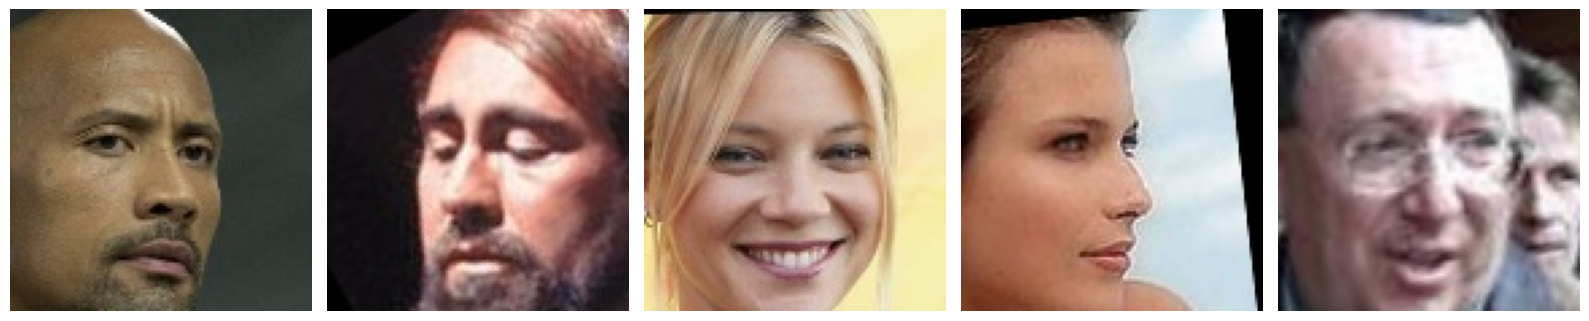

In [ ]:
#@title Show images
sample_images, _ = next(iter(dl_umd_train))
show_images(sample_images, inv_normalize=inv_normalize)

In [ ]:
#@title Measuring reading vs transformation time
import time
import torch
from torch.utils.data import DataLoader, Dataset

class AverageMeter:
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Define function to measure time
def measure_time(loader, read_meter, transform_meter, transform=None):
    start = time.time()
    for batch in loader:
        end_read = time.time()
        read_meter.update(end_read - start)

        if transform:
            batch = [transform(sample) for sample in batch]

        end_transform = time.time()
        transform_meter.update(end_transform - end_read)

        # Simulate processing time
        # time.sleep(0.01)
        start = time.time()

    print(f"Average time for reading data: {read_meter.avg:.6f} seconds")
    print(f"Average time for applying transformations: {transform_meter.avg:.6f} seconds")

use_time_measure = False

if use_time_measure:
    loader = FaceDataset(UMD_DATA_DIR, split='train', limit_labels=limit_labels)

    # Initialize AverageMeter
    read_meter = AverageMeter()
    transform_meter = AverageMeter()

    # Measure time without transformations
    measure_time(loader, read_meter, transform_meter)

    # Measure time with transformations
    read_meter.reset()
    transform_meter.reset()
    measure_time(loader, read_meter, transform_meter, transform=transform_train)

## Contrastive sampler

Создадим кастомный сэмплер, который обладает следующими свойствами:

1. В каждом батче размера $B$ присутствуют изображения ровно для $P$ персон, по $K$ изображений на каждого. При этом если в процессе формирования очередного батча для какой-либо персоны остается меньше $K$ изображений, они не используются.

2. Выбор изображений для каждого батча происходит без повторений - каждое изображение в датасете либо используется единожды, либо не используется (так как невозможного сформировать батч с заданными параметрами)


In [ ]:
# create a mask for used images for each id

ds_train = ds_umd_train

id_to_idx = {
    id: ma.array(idx, mask=np.zeros(len(idx), dtype=bool))
    for id, idx in ds_train.id_to_idx.items()
}

id_to_idx[list(id_to_idx.keys())[0]]

masked_array(data=[25486, 25487, 25488, 25489, 25490, 25491, 25492, 25493,
                   25494, 25495, 25496, 25497, 25498, 25499, 25500, 25501,
                   25502, 25503, 25504, 25505, 25506, 25507, 25508, 25509,
                   25510, 25511, 25512, 25513, 25514, 25515, 25516, 25517,
                   25518, 25519, 25520, 25521, 25522, 25523, 25524],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False],
       fill_value=999999)

In [ ]:
# discard ids with images count less than theshold

imgs_per_id = 20

id_to_idx = {
    id: idx
    for id, idx in id_to_idx.items() if len(idx) >= imgs_per_id
}

In [ ]:
# create a mask for ids all images of which have been used

all_ids_cnt = len(id_to_idx.keys())
all_ids = ma.array(
    list(id_to_idx.keys()), # assume label encoding: [0, N-1]
    mask=np.zeros(all_ids_cnt, dtype=bool)
    )
all_ids[:10]

masked_array(data=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value=999999)

In [ ]:
# choose random ids for which not all of the images are used

ids_per_batch = 3

batch_ids = np.random.choice(all_ids[~all_ids.mask], ids_per_batch, replace=False)
batch_ids

array([754, 412, 620])

In [ ]:
# choose random images indices for each chosen id

all_indices = []
for id in batch_ids:
    idx = id_to_idx[id]
    idx_indices = np.arange(len(idx))
    pos_idx_indices = np.random.choice(
        idx_indices[~idx.mask], # ignore all used images
        imgs_per_id, replace=False
    )

    all_indices.append(idx[pos_idx_indices].data)
    id_to_idx[id].mask[pos_idx_indices] = True # mask used images

all_indices = np.concatenate(all_indices)
all_indices

array([28760, 28775, 28761, 28771, 28766, 28778, 28772, 28757, 28767,
       28769, 28770, 28765, 28768, 28773, 28776, 28758, 28759, 28762,
       28777, 28764, 20289, 20333, 20310, 20291, 20311, 20304, 20332,
       20305, 20282, 20316, 20284, 20303, 20325, 20281, 20300, 20313,
       20280, 20318, 20321, 20319, 18368, 18357, 18311, 18377, 18381,
       18342, 18380, 18345, 18318, 18326, 18340, 18338, 18379, 18327,
       18321, 18376, 18360, 18372, 18359, 18370])

In [ ]:
# masks of used images are updated for each id in current batch

for id in batch_ids:
    print(id_to_idx[id].mask)

[ True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True False]
[False  True  True  True False  True False False False False  True False
  True False False False False False False False False  True False False
  True  True  True False False False False  True  True False  True False
 False  True False  True  True False  True False False False  True False
 False False False False False  True  True]
[False False False False False False False False False False False  True
 False False False False False False  True False False  True False False
 False False  True  True False False False False False False False False
 False False  True False  True False  True False False  True False False
 False False False False False False False False False  True False  True
  True False False False False False False False  True False  True False
  True False False False  True  True False  True  True  True False False
 False False

In [ ]:
# mask ids all images of which were used (and thus the list of available images got exhausted)

for id in batch_ids:
    idx = id_to_idx[id]
    unused_imgs_cnt = len(idx) - idx.mask.sum() # unused images count

    # mask id if too small image count
    all_ids.mask[all_ids == id] = unused_imgs_cnt < imgs_per_id

all_ids[np.isin(all_ids, batch_ids)]

masked_array(data=[412, 620, --],
             mask=[False, False,  True],
       fill_value=999999)

In [ ]:
from copy import deepcopy
from time import perf_counter
from datetime import timedelta
from torch.utils.data import BatchSampler

# TODO: use remaining images to generate batches, not just discard them
# TODO: precalculate precise number of batches

#@title UniformContrastiveSampler
class UniformContrastiveSampler(BatchSampler):
    def __init__(self, dataset, imgs_per_id, batch_size, shuffle=True, seed=None):
        """
        Creates uniform batches such that each batch contains:
            - same number of ids
            - same number of images per each id
        Ids and images are sampled at random WITHOUT replacement,
        meaning that the sampler is guaranteed to:
            - use all possible images and all possible ids
            - create fully unique batches (which do NOT contain same images)

        In a batch number of positives per anchor equals imgs_per_id - 1.
        params:
            imgs_per_id: number of images sampled per id
            batch_size: ...
            shuffle: whether to reshuffle data every epoch (default: False)
            seed: seed used for shuffling if shuffling is enabled
        """
        assert batch_size % imgs_per_id == 0, "batch_size should be divisible by img_per_id"

        self.imgs_per_id = imgs_per_id
        self.batch_size = batch_size
        self.ids_per_batch = int(batch_size / imgs_per_id)

        # discard ids with images count less than theshold
        self.id_to_idx = {
            id: idx
            for id, idx in dataset.id_to_idx.items() if len(idx) >= self.imgs_per_id
        }

        self.shuffle = shuffle

        if shuffle == False:
            self.seed = seed if seed is not None else 42
        else:
            self.seed = None

        tic = perf_counter()
        self.all_indices = self._compute_all_indices()
        toc = perf_counter()

        print(
            f"Time spent generating {self.total_batches} batches" \
            f" of size {self.batch_size}" \
            f" for {self.imgs_per_id} images per id" \
            f" for {self.ids_per_batch} ids per batch" \
            f" : {timedelta(seconds=toc-tic)}" \
            f"\nUnused imgs count: {self.total_unused_imgs_cnt}\n"
        )

    def _compute_all_indices(self):
        rng = np.random.default_rng(self.seed)

        # create a mask for used images for each id
        id_to_idx = {
            id: ma.array(idx, mask=np.zeros(len(idx), dtype=bool))
            for id, idx in self.id_to_idx.items()
        }

        # create a mask for ids all images of which have been used
        all_ids_cnt = len(id_to_idx.keys())
        all_ids = ma.array(
            list(id_to_idx.keys()),
            mask=np.zeros(all_ids_cnt, dtype=bool)
            )

        total_batches = 0
        total_unused_imgs_cnt = 0
        all_indices = []
        while len(all_ids[~all_ids.mask]) >= self.ids_per_batch:
            # choose random ids for which not all of the images are used
            batch_ids = rng.choice(
                all_ids[~all_ids.mask],
                self.ids_per_batch, replace=False
            )

            # choose images indices for each id
            for id in batch_ids:
                idx = id_to_idx[id]
                idx_indices = np.arange(len(idx))
                pos_idx_indices = rng.choice(
                    idx_indices[~idx.mask], # ignore all used images
                    self.imgs_per_id, replace=False
                )

                all_indices.append(idx[pos_idx_indices].data)
                id_to_idx[id].mask[pos_idx_indices] = True # mask used images

                unused_imgs_cnt = len(idx) - idx.mask.sum()
                all_ids.mask[all_ids.data == id] = unused_imgs_cnt < self.imgs_per_id

            total_batches += 1


        all_indices = np.concatenate(all_indices)
        self.total_batches = total_batches

        total_unused_imgs_cnt = 0
        for id, idx in id_to_idx.items():
            total_unused_imgs_cnt = len(idx) - idx.mask.sum()
        self.total_unused_imgs_cnt = total_unused_imgs_cnt

        # TODO: precalculate precise number of batches
        # total_batches = sum([len(idx) // self.imgs_per_id for id, idx in self.id_to_idx.items()]) \
        #     / self.ids_per_batch
        # print(self.total_batches, total_batches)

        return all_indices

    def __iter__(self):
        # compute indices if not precomputed
        if self.all_indices is None:
            self.all_indices = self._compute_all_indices()

        all_indices = deepcopy(self.all_indices)
        self.all_indices = None # remove precomputed for next epoch

        for i in range(0, len(all_indices), self.batch_size):
            yield all_indices[i:i + self.batch_size]

    def __len__(self):
        return self.total_batches

In [ ]:
#@title Contrastive dataloaders getter

def get_dataloaders_contrastive(
        ds_train, ds_valid, ds_test,
        imgs_per_id, batch_size
        ):
    common_sampler_opts = dict(
        imgs_per_id=imgs_per_id,
        batch_size=batch_size,
    )

    contrastive_sampler_train = UniformContrastiveSampler(
        **common_sampler_opts,
        dataset=ds_train,
        shuffle=True
    )

    contrastive_sampler_valid = UniformContrastiveSampler(
        **common_sampler_opts,
        dataset=ds_valid,
        shuffle=False
    )

    contrastive_sampler_test = UniformContrastiveSampler(
        **common_sampler_opts,
        dataset=ds_test,
        shuffle=False
    )

    dl_contrastive_train = DataLoader(ds_train, batch_sampler=contrastive_sampler_train)
    dl_contrastive_valid = DataLoader(ds_valid, batch_sampler=contrastive_sampler_valid)
    dl_contrastive_test = DataLoader(ds_test, batch_sampler=contrastive_sampler_test)

    return dl_contrastive_train, dl_contrastive_valid, dl_contrastive_test

In [ ]:
dl_contrastive_train, dl_contrastive_valid, dl_contrastive_test =  \
get_dataloaders_contrastive(
    ds_umd_train, ds_umd_valid, ds_umd_test,
    imgs_per_id=4,
    batch_size=16
)

Time spent generating 2122 batches of size 16 for 4 images per id for 4 ids per batch : 0:00:00.608512
Unused imgs count: 1

Time spent generating 333 batches of size 16 for 4 images per id for 4 ids per batch : 0:00:00.105454
Unused imgs count: 2

Time spent generating 330 batches of size 16 for 4 images per id for 4 ids per batch : 0:00:00.087078
Unused imgs count: 1



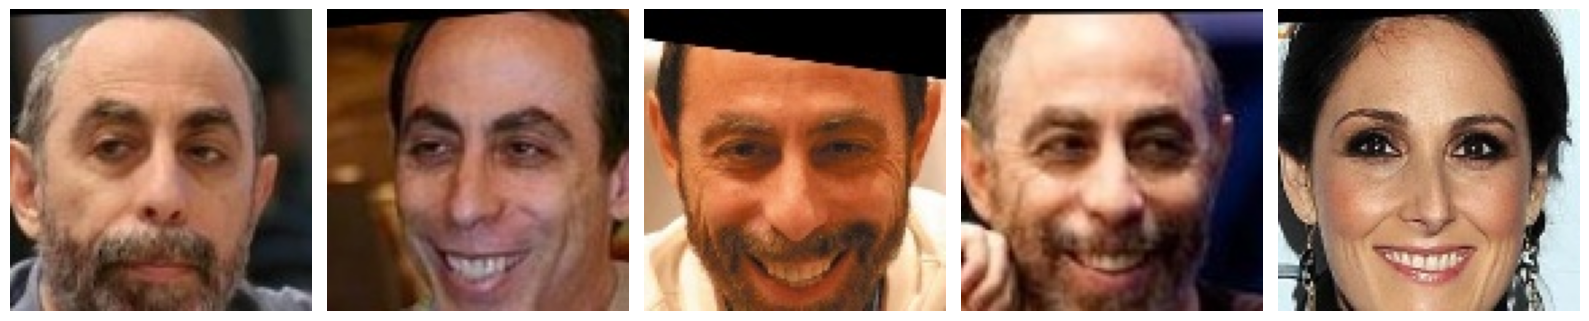

In [ ]:
batch = next(iter(dl_contrastive_train))
imgs, labels = batch
show_images(imgs, inv_normalize=inv_normalize)

In [ ]:
# valid/test loaders are reproducible across epochs

_, labels1 = next(iter(dl_contrastive_valid))
_, labels2 = next(iter(dl_contrastive_valid))
torch.allclose(labels1, labels2)

True

In [ ]:
# train loader is NOT reproducible across epochs

_, labels1 = next(iter(dl_contrastive_train))
_, labels2 = next(iter(dl_contrastive_train))
torch.allclose(labels1, labels2)

False

## Dataset: Cifar-10

In [ ]:
from torch.utils.data import random_split
RESCALE_SIZE = 112

# CIFAR-10 DataModule
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, val_pct=0.2, batch_size=32):
        super().__init__()
        self.num_classes = 10
        self.batch_size = batch_size
        self.val_pct = val_pct
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE), antialias=False),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def prepare_data(self):
        CIFAR10(root='./data', train=True, download=True)
        CIFAR10(root='./data', train=False, download=True)

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            dataset = CIFAR10(root='./data', train=True, transform=self.transform)
            self.train_dataset, self.val_dataset = random_split(
                dataset,
                [(1-self.val_pct), self.val_pct]
                )
        if stage == 'test' or stage is None:
            self.test_dataset = CIFAR10(root='./data', train=False, transform=self.transform)

    def set_batch_size(self, batch_size):
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)

## Dataset: LFW

In [ ]:
from PIL import Image

class CustomCrop(object):
    def __init__(self, top, bottom, left, right):
        self.top = top
        self.bottom = bottom
        self.left = left
        self.right = right

    def __call__(self, img):
        img = img[:, self.top:self.bottom, self.left:self.right]
        return img

class SquarePad(object):
	def __call__(self, image):
		h, w = image.size(-2), image.size(-1)
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return transforms.functional.pad(image, padding, 0, 'constant')

In [ ]:
def calc_center_crop_coords(image_size, crop_size):
    if crop_size > image_size:
        raise ValueError("Crop size must be smaller than or equal to the image size.")

    center = image_size // 2
    half_crop = crop_size // 2

    top = center - half_crop
    bottom = center + half_crop
    left = center - half_crop
    right = center + half_crop

    return (top, bottom, left, right)

# Example usage
image_size = 250
crop_size = 140

crop_coords = calc_center_crop_coords(image_size, crop_size)
print(f"Crop coordinates: {crop_coords}")

Crop coordinates: (55, 195, 55, 195)


In [ ]:
# rectangle crop & pad to square
rectangle_crop_pad = [
    CustomCrop(*crop_coords),
    SquarePad(),
]

# square crop
square_crop = [
    CustomCrop(*crop_coords),
]

In [ ]:
MEAN = np.array([127.5, 127.5, 127.5])
STD = np.array([128, 128, 128])

transform = transforms.Compose([
    transforms.ToTensor(),
    # *square_crop,
    *rectangle_crop_pad,
    transforms.Resize((112, 112), antialias=False),

    # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # [0, 1] - > [-1, 1]

    transforms.Normalize([0, 0, 0], [1/255, 1/255, 1/255]), # [0, 1] -> [1, 255]
    # transforms.Normalize(MEAN, STD), # [1, 255] -> [-1, 1]
])

inv_normalize = transforms.Normalize(
    mean = -np.array(MEAN) / np.array(STD),
    std = 1 / STD
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
# MEAN = np.array([127.5, 127.5, 127.5])
# STD = np.array([128, 128, 128])

def get_transform(norm_range=None):
    # from [0, 1] to ...
    norm_stats_dict = {
        '[-1, 1]': dict(
            mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
        ),
        '[0, 255]': dict(
            mean=[0, 0, 0], std=[1/255, 1/255, 1/255]
        ),
    }

    assert norm_range in norm_stats_dict.keys() or norm_range is None


    if norm_range is None:
        norm_transforms = []
    else:
        norm_stats = norm_stats_dict[norm_range]
        norm_transforms = [transforms.Normalize(**norm_stats)]

        inv_normalize = transforms.Normalize(
            mean = -np.array(norm_stats['mean']) / np.array(norm_stats['std']),
            std = 1 / STD
        ) # [*, *] -> [0, 1]

    transform = transforms.Compose([
        transforms.ToTensor(),
        # *square_crop,
        *rectangle_crop_pad,
        transforms.Resize((112, 112), antialias=False),
        *norm_transforms
    ])

    return transform, inv_normalize

In [ ]:
#@title Dataset getter

%%capture

from torchvision.datasets import LFWPairs
from tqdm import tqdm

def get_datasets_lfw(norm_range):
    # TODO: fix hack
    global inv_normalize
    transform, inv_normalize = get_transform(norm_range)
    ds_test = LFWPairs(
        root='./data', split='test', transform=transform, download=True,
        image_set='deepfunneled'
    )

    return ds_test

ds_lfw = get_datasets_lfw(norm_range='[-1, 1]')
dl_lfw = DataLoader(ds_lfw, batch_size=5, shuffle=False)

### Show images

In [ ]:
iterator = iter(dl_lfw)

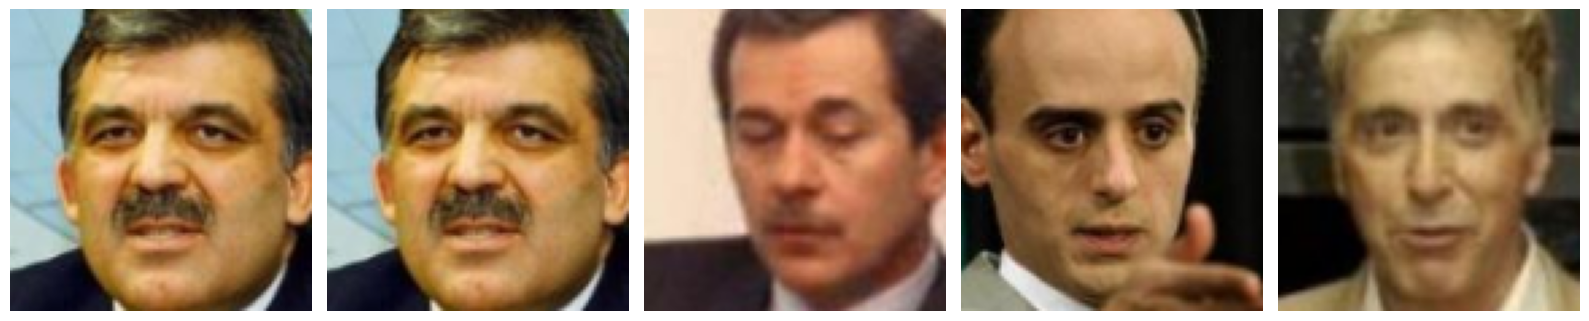

In [ ]:
imgs, *_ = next(iterator)
show_images(imgs, inv_normalize=inv_normalize)

# Loss modules

In [ ]:
#@title SoftmaxLoss module
class SoftmaxLoss(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxLoss, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, inputs, targets):
        # Apply linear layer
        logits = self.linear(inputs)

        # Calculate cross-entropy loss
        loss = F.cross_entropy(logits, targets)

        return loss, logits

In [ ]:
#@title CombinedMarginLoss module
import math

class CombinedMarginLoss(nn.Module):
    def __init__(self, s, m1, m2, m3, num_classes, emb_dim):
        super().__init__()
        self.s = s
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.weight = nn.Parameter(torch.Tensor(num_classes, emb_dim))
        nn.init.xavier_uniform_(self.weight)

        self.cos_m2 = math.cos(self.m2)
        self.sin_m2 = math.cos(self.m2)

    def forward(self, embs, labels):
        cos_theta = F.linear(F.normalize(embs), F.normalize(self.weight))
        cos_theta = cos_theta.float()

        cos_theta = cos_theta.clamp(-1, 1) # for arccos
        theta = torch.acos(cos_theta)

        # apply SphereFace penalty
        theta_m1 = theta * self.m1
        cos_theta_m1 = torch.cos(theta_m1)
        sin_theta_m1 = torch.sqrt(1 - torch.pow(cos_theta_m1, 2)) # by trig identity

        # apply ArcFace penalty
        cos_theta_m1_m2 = cos_theta_m1 * self.cos_m2 - sin_theta_m1 * self.sin_m2

        # apply CosFace penalty
        cos_theta_m1_m2_m3 = cos_theta_m1_m2 - self.m3

        one_hot = torch.zeros_like(cos_theta, dtype=torch.bool)
        one_hot.scatter_(1, labels.view(-1, 1), True)

        cos_theta_adjusted = cos_theta.clone()
        cos_theta_adjusted[one_hot] = cos_theta_m1_m2_m3[one_hot]
        cos_theta_adjusted = cos_theta_adjusted * self.s
        loss = F.cross_entropy(cos_theta_adjusted, labels)

        # TODO: more efficient memory usage with scatter_
        # cos_theta.scatter_(0, labels.view(-1, 1), cos_theta_m1_m2_m3[one_hot])
        # cos_theta = cos_theta * self.s
        # loss = F.cross_entropy(cos_theta, labels)

        return loss, cos_theta_adjusted

In [ ]:
#@title Combined Margin loss module (reference implementation)
class ReferenceCombinedMarginLoss(torch.nn.Module):
    def __init__(self,
                 s,
                 m1,
                 m2,
                 m3,
                 num_classes,
                 emb_dim,
                 interclass_filtering_threshold=0):
        super().__init__()
        self.s = s
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.interclass_filtering_threshold = interclass_filtering_threshold
        self.weight = nn.Parameter(torch.Tensor(num_classes, emb_dim))
        nn.init.xavier_uniform_(self.weight)

        # For ArcFace
        self.cos_m = math.cos(self.m2)
        self.sin_m = math.sin(self.m2)
        self.theta = math.cos(math.pi - self.m2)
        self.sinmm = math.sin(math.pi - self.m2) * self.m2
        self.easy_margin = False


    def forward(self, embs, labels):
        logits = F.linear(F.normalize(embs), F.normalize(self.weight))
        logits = logits.float().clamp(-1, 1)
        index_positive = torch.where(labels != -1)[0]

        if self.interclass_filtering_threshold > 0:
            with torch.no_grad():
                dirty = logits > self.interclass_filtering_threshold
                dirty = dirty.float()
                mask = torch.ones([index_positive.size(0), logits.size(1)], device=logits.device)
                mask.scatter_(1, labels[index_positive], 0)
                dirty[index_positive] *= mask
                tensor_mul = 1 - dirty
            logits = tensor_mul * logits

        target_logit = logits[index_positive, labels[index_positive].view(-1)]

        if self.m1 == 1.0 and self.m3 == 0.0:
            with torch.no_grad():
                target_logit.arccos_()
                logits.arccos_()
                final_target_logit = target_logit + self.m2
                logits[index_positive, labels[index_positive].view(-1)] = final_target_logit
                logits.cos_()
            logits = logits * self.s

        elif self.m3 > 0:
            final_target_logit = target_logit - self.m3
            logits[index_positive, labels[index_positive].view(-1)] = final_target_logit
            logits = logits * self.s
        else:
            raise

        loss = F.cross_entropy(logits, labels)

        return loss, logits

In [ ]:
#@title TripletBatchHardLoss module

class PairwiseDistances(nn.Module):
    def __init__(self, squared):
        super().__init__()
        self.squared = squared

    def forward(self, embeddings):
        dot_product = torch.mm(embeddings, embeddings.T)
        square_norm = torch.diag(dot_product)

        dist = square_norm.reshape(1, -1) - 2.0 * dot_product + square_norm.reshape(1, -1).T
        dist = F.relu(dist) # fix negative distances from computation errors

        if not self.squared:
            mask = torch.eq(dist, 0)
            dist = dist + mask * 1e-16 # make sure not to divide by 0 in grad of sqrt(x)
            dist = torch.sqrt(dist)
            dist = dist * (~mask) # remove epsilon

        return dist

class TripletBatchHardLoss(nn.Module):
    def __init__(self,
                 margin,
                 squared=False,
                 num_classes=None # for Loss module interface consistency
                 ):
        super().__init__()
        self.margin = margin
        self.pairwise_distances = PairwiseDistances(squared)

    def forward(self, embeddings, labels):
        embeddings = F.normalize(embeddings)
        dist = self.pairwise_distances(embeddings)

        # get anchor posititve triplet mask
        indices_not_equal = ~torch.eye(labels.shape[0], dtype=bool, device=labels.device)
        labels_equal = torch.eq(labels.reshape(1, -1), labels.reshape(-1, 1))
        mask_anchor_pos = torch.logical_and(indices_not_equal, labels_equal).float()

        # get anchor negative triplet mask
        mask_anchor_neg = ( ~torch.eq(labels.reshape(1, -1), labels.reshape(-1, 1)) ).float()

        # get distance only for positives/neg
        anchor_pos_dist = dist * mask_anchor_pos
        anchor_neg_dist = dist * mask_anchor_neg

        # select hardest pos
        hardest_pos_dist, _ = anchor_pos_dist.max(1, keepdim=True)

        # select hardest neg
        # TODO: explain why not just take min for negatives
        max_anchor_neg_dist, _= anchor_neg_dist.max(1, keepdim=True)
        anchor_neg_dist = dist + max_anchor_neg_dist * (1.0 - mask_anchor_neg)
        hardest_neg_dist, _ = anchor_neg_dist.min(1, keepdim=True)
        loss = F.relu(hardest_pos_dist - hardest_neg_dist + self.margin)
        loss = loss.mean()
        return loss

In [ ]:
#@title SupervisedContrastiveLoss (reference implementation)
class ReferenceSupervisedContrastiveLoss(nn.Module):
    """
    Multi-Positive Contrastive Loss: https://arxiv.org/pdf/2306.00984.pdf
    """

    def __init__(self,
                 temperature,
                 num_classes=None # for Loss module interface consistency
                 ):

        super().__init__()

        self.temperature = temperature
        self.logits_mask = None
        self.mask = None
        self.last_local_batch_size = None

    def set_temperature(self, temp=0.1):
        self.temperature = temp

    def forward(self, feats, labels):
        # feats = outputs['feats']    # feats shape: [B, D]
        # labels = outputs['labels']    # labels shape: [B]

        device = (torch.device('cuda')
                  if feats.is_cuda
                  else torch.device('cpu'))

        feats = F.normalize(feats, dim=-1, p=2)
        local_batch_size = feats.size(0)

        # all_feats = torch.cat(torch.distributed.nn.all_gather(feats), dim=0)
        # all_labels = concat_all_gather(labels)  # no gradient gather

        all_feats = feats
        all_labels = labels  # no gradient gather

        # compute the mask based on labels
        if local_batch_size != self.last_local_batch_size:
            mask = torch.eq(labels.view(-1, 1),
                            all_labels.contiguous().view(1, -1)).float().to(device)
            self.logits_mask = torch.scatter(
                torch.ones_like(mask),
                1,
                torch.arange(mask.shape[0]).view(-1, 1).to(device) +
                # local_batch_size * misc.get_rank(),
                local_batch_size * 0,
                0
            )

            self.last_local_batch_size = local_batch_size
            self.mask = mask * self.logits_mask

        mask = self.mask

        # compute logits
        logits = torch.matmul(feats, all_feats.T) / self.temperature
        logits = logits - (1 - self.logits_mask) * 1e9

        # optional: minus the largest logit to stablize logits
        # logits = stablize_logits(logits)

        # compute ground-truth distribution
        p = mask / mask.sum(1, keepdim=True).clamp(min=1.0)
        # loss = compute_cross_entropy(p, logits)
        loss = F.cross_entropy(logits, p)

        # return {'loss': loss, 'image_loss': loss}
        return loss

MultiPosConLoss = ReferenceSupervisedContrastiveLoss

# Model

In [ ]:
#@title Backbone: SimpleCNN
class SimpleCNN(nn.Module):
    def __init__(self, num_features):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_features)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
#@title Backbone: Mobile FaceNet

# COPY-PASTE FROM https://github.com/deepinsight/insightface/blob/a61a1dd46644a25991426186cf452ab01a9f4a5c/recognition/combined_margin__torch/backbones/mobilefacenet.py

'''
Adapted from https://github.com/cavalleria/cavaface.pytorch/blob/master/backbone/mobilefacenet.py
Original author cavalleria
'''

class Flatten(Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class ConvBlock(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(ConvBlock, self).__init__()
        self.layers = nn.Sequential(
            Conv2d(in_c, out_c, kernel, groups=groups, stride=stride, padding=padding, bias=False),
            BatchNorm2d(num_features=out_c),
            PReLU(num_parameters=out_c)
        )

    def forward(self, x):
        return self.layers(x)


class LinearBlock(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(LinearBlock, self).__init__()
        self.layers = nn.Sequential(
            Conv2d(in_c, out_c, kernel, stride, padding, groups=groups, bias=False),
            BatchNorm2d(num_features=out_c)
        )

    def forward(self, x):
        return self.layers(x)


class DepthWise(Module):
    def __init__(self, in_c, out_c, residual=False, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=1):
        super(DepthWise, self).__init__()
        self.residual = residual
        self.layers = nn.Sequential(
            ConvBlock(in_c, out_c=groups, kernel=(1, 1), padding=(0, 0), stride=(1, 1)),
            ConvBlock(groups, groups, groups=groups, kernel=kernel, padding=padding, stride=stride),
            LinearBlock(groups, out_c, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        )

    def forward(self, x):
        short_cut = None
        if self.residual:
            short_cut = x
        x = self.layers(x)
        if self.residual:
            output = short_cut + x
        else:
            output = x
        return output


class Residual(Module):
    def __init__(self, c, num_block, groups, kernel=(3, 3), stride=(1, 1), padding=(1, 1)):
        super(Residual, self).__init__()
        modules = []
        for _ in range(num_block):
            modules.append(DepthWise(c, c, True, kernel, stride, padding, groups))
        self.layers = Sequential(*modules)

    def forward(self, x):
        return self.layers(x)


class GDC(Module):
    def __init__(self, embedding_size):
        super(GDC, self).__init__()
        self.layers = nn.Sequential(
            LinearBlock(512, 512, groups=512, kernel=(7, 7), stride=(1, 1), padding=(0, 0)),
            Flatten(),
            Linear(512, embedding_size, bias=False),
            BatchNorm1d(embedding_size))

    def forward(self, x):
        return self.layers(x)


class MobileFaceNet(Module):
    def __init__(self, num_features=512, blocks=(1, 4, 6, 2), scale=2):
        super(MobileFaceNet, self).__init__()
        self.scale = scale
        # self.fp16 = fp16
        self.layers = nn.ModuleList()
        self.layers.append(
            ConvBlock(3, 64 * self.scale, kernel=(3, 3), stride=(2, 2), padding=(1, 1))
        )
        if blocks[0] == 1:
            self.layers.append(
                ConvBlock(64 * self.scale, 64 * self.scale, kernel=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
            )
        else:
            self.layers.append(
                Residual(64 * self.scale, num_block=blocks[0], groups=128, kernel=(3, 3), stride=(1, 1), padding=(1, 1)),
            )

        self.layers.extend(
        [
            DepthWise(64 * self.scale, 64 * self.scale, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=128),
            Residual(64 * self.scale, num_block=blocks[1], groups=128, kernel=(3, 3), stride=(1, 1), padding=(1, 1)),
            DepthWise(64 * self.scale, 128 * self.scale, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=256),
            Residual(128 * self.scale, num_block=blocks[2], groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1)),
            DepthWise(128 * self.scale, 128 * self.scale, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=512),
            Residual(128 * self.scale, num_block=blocks[3], groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1)),
        ])

        self.conv_sep = ConvBlock(128 * self.scale, 512, kernel=(1, 1), stride=(1, 1), padding=(0, 0))
        self.features = GDC(num_features)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        # with torch.cuda.amp.autocast(self.fp16):
        for func in self.layers:
            x = func(x)
        # x = self.conv_sep(x.float() if self.fp16 else x)
        x = self.conv_sep(x)
        x = self.features(x)
        return x


def get_mbf(num_features, blocks=(1, 4, 6, 2), scale=2):
    return MobileFaceNet(num_features, blocks, scale=scale)

def get_mbf_large(num_features, blocks=(2, 8, 12, 4), scale=4):
    return MobileFaceNet(num_features, blocks, scale=scale)


In [ ]:
#@title FaceRecognitionModel v0 (Lightning module)

# TODO: apply different options for backbone submodule groups
# TODO: use KNN for validating accuracy

import gc

class FaceRecognitionModel_v0(pl.LightningModule):
    def __init__(self,
                 backbone_getter, backbone_hparams,
                 LossModuleClass, loss_module_hparams,
                 optim_hparams, scheduler_hparams,
                 SchedulerClass=None, scheduler_monitor_metric="loss/valid",
                #  use_knn_acc=False, **knn_hparams,
                #  optim_submodules_options,
                 ):
        super().__init__()

        self.save_hyperparameters()
        self.backbone = backbone_getter(**backbone_hparams)
        self.loss_module = LossModuleClass(**loss_module_hparams)

        # if use_knn_acc is not None:
        #     self.knn = KNeighborsClassifier(**knn_hparams)

    def forward(self, imgs):
        return self.backbone(imgs)

    def configure_optimizers(self):
        # optim_param_groups = get_parameter_groups(
        #     self.backbone,
        #     self.hparams.optim_submodules_options,
        # )

        optimizer = torch.optim.SGD(
            # optim_param_groups,
            [
                {"params": self.backbone.parameters()},
                {"params": self.loss_module.parameters()},
            ],
            **self.hparams.optim_hparams
        )

        if self.hparams.SchedulerClass is not None:
            SchedulerClass = self.hparams.SchedulerClass
        else:
            SchedulerClass = MultiStepLR

        scheduler = SchedulerClass(
            optimizer,
            **self.hparams.scheduler_hparams
        )

        # print("Configured optimizers:")
        # print(f"     optimizer_hparams: {self.hparams.optim_hparams}")
        # print(f"     scheduler_hparams: {self.hparams.scheduler_hparams}")

        return {
            'optimizer': optimizer,
            'scheduler': scheduler,
            'monitor': self.hparams.scheduler_monitor_metric
        }


    def training_step(self, batch, batch_idx):
        *imgs, labels = batch
        embeddings = [self.backbone(img) for img in imgs]
        loss = self.loss_module(*embeddings, labels)

        # if self.use_knn_acc:
        #     self.embs_precomputed.append(embeddings)
        #     self.labels_precomputed.append(labels)

        self.log("loss/train", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        *imgs, labels = batch
        embeddings = [self.backbone(img) for img in imgs]
        loss = self.loss_module(*embeddings, labels)

        # if self.use_knn_acc:
        #     self.embs_precomputed.append(embeddings)
        #     self.labels_precomputed.append(labels)

        self.log("loss/valid", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        *imgs, labels = batch
        embeddings = [self.backbone(img) for img in imgs]
        loss = self.loss_module(*embeddings, labels)

        # if self.use_knn_acc:
        #     self.embs_precomputed.append(embeddings)
        #     self.labels_precomputed.append(labels)

        self.log("loss/test", loss, prog_bar=True)
        return loss

    # def __fit_evaluate_classifier(self):
    #     self.embs_precomputed = torch.cat(self.embs_precomputed)
    #     self.labels_precomputed = torch.cat(self.labels_precomputed)

    #     self.custom_classifier.fit(self.embeddings, self.labels)
    #     labels_pred = self.custom_classifier.predict(self.embeddings)

    #     del self.embs_precomputed, self.lab
    #     gc.collect()
    #     torch.cuda.empty_cache()

    # def on_train_epoch_start(self):
    #     self.embs_precomputed = []
    #     self.labels_precomputed = []

    # def on_train_epoch_end(self):
    #     acc = self.__fit_evaluate_classifier(self.embs_precomputed)

    #     self.log("acc/train", acc, on_epoch=True)


In [ ]:
#@title FaceRecognitionModel v1 (Lightning module)

# TODO: apply different options for backbone submodule groups

class FaceRecognitionModel(pl.LightningModule):
    def __init__(self,
                 BackboneClass, backbone_hparams,
                 LossModuleClass, loss_module_hparams,
                 OptimClass, optim_hparams,
                 SchedulerClass=None, scheduler_hparams=None,
                 scheduler_monitor_metric="loss/valid/dataloader_idx_0",
                #  optim_submodules_options,
                 ):
        if SchedulerClass is not None:
            assert scheduler_hparams is not None

        if scheduler_hparams is not None:
            assert SchedulerClass is not None

        super().__init__()

        self.save_hyperparameters()
        self.backbone = BackboneClass(**backbone_hparams)
        self.loss_module = LossModuleClass(**loss_module_hparams)

        self.num_classes = loss_module_hparams['num_classes']
        self.acc_train = Accuracy(task="multiclass", num_classes=self.num_classes, top_k=1)
        self.acc_valid = Accuracy(task="multiclass", num_classes=self.num_classes, top_k=1)
        self.acc_test = Accuracy(task="multiclass", num_classes=self.num_classes, top_k=1)

    def configure_optimizers(self):
        optimizer = self.hparams.OptimClass(self.parameters(), **self.hparams.optim_hparams)

        if self.hparams.SchedulerClass is not None:
            scheduler = self.hparams.SchedulerClass(optimizer, **self.hparams.scheduler_hparams)
        else:
            scheduler = None

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': self.hparams.scheduler_monitor_metric
            }
        }

    def forward(self, imgs):
        return self.backbone(imgs)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        embeddings = self.backbone(imgs)

        loss, logits = self.loss_module(embeddings, labels)
        acc = self.acc_train(logits, labels)

        self.log('acc/train', acc, sync_dist=True)
        self.log("loss/train", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        embeddings = self.backbone(imgs)

        loss, logits = self.loss_module(embeddings, labels)
        acc = self.acc_valid(logits, labels)

        self.log('acc/valid', acc, sync_dist=True)
        self.log("loss/valid", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        embeddings = self.backbone(imgs)

        loss, logits = self.loss_module(embeddings, labels)
        acc = self.acc_test(logits, labels)

        self.log('acc/test', acc, sync_dist=True)
        self.log("loss/test", loss, prog_bar=True)
        return loss

In [ ]:
#@title FaceRecognitionModel, Verification ACC  on Out-of-sample
from torchmetrics.classification import BinaryAccuracy

class FaceRecognitionModelWithVerficationAccuracy(FaceRecognitionModel):
    def __init__(self, acc_ver_fpr=1e-4, roc_thresholds=40, loss_returns_logits=False,
                 scheduler_monitor_metric="loss/valid/dataloader_idx_0",
                 **kwargs):
        super().__init__(scheduler_monitor_metric=scheduler_monitor_metric, **kwargs)

        self.acc_ver_fpr = acc_ver_fpr
        self.loss_returns_logits = loss_returns_logits

        self.save_hyperparameters(ignore='kwargs')

        if self.hparams.acc_ver_fpr is not None:
            self.roc_valid = BinaryROC(thresholds=roc_thresholds)
            self.roc_test = BinaryROC(thresholds=roc_thresholds)
        else:
            self.acc_valid = BinaryAccuracy(threshold=0.5)
            self.acc_test = BinaryAccuracy(threshold=0.5)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        embeddings = self.backbone(imgs)

        if self.hparams.loss_returns_logits:
            loss, logits = self.loss_module(embeddings, labels)
        else:
            loss = self.loss_module(embeddings, labels)

        self.log("loss/train", loss, prog_bar=True)

        # acc = self.acc_train(logits, labels)
        # self.log('acc/train', acc, sync_dist=True)

        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        if dataloader_idx == 0:
            imgs, labels = batch
            embeddings = self.backbone(imgs)

            if self.hparams.loss_returns_logits:
                loss, logits = self.loss_module(embeddings, labels)
            else:
                loss = self.loss_module(embeddings, labels)

            self.log("loss/valid", loss, prog_bar=True)

            return loss

        elif dataloader_idx == 1:
            imgs1, imgs2, labels = batch

            embs1 = self.backbone(imgs1)
            embs2 = self.backbone(imgs2)

            cos_sim = F.cosine_similarity(embs1, embs2)
            if self.hparams.acc_ver_fpr is not None:
                self.roc_valid.update(cos_sim, labels)
            else:
                acc_ver = self.acc_valid(cos_sim, labels)
                self.log("acc_ver/valid", acc_ver, prog_bar=True)

            return None

    def on_validation_epoch_end(self):
        if self.hparams.acc_ver_fpr is not None:
            fpr, tpr, _ = self.roc_valid.compute()
            acc_ver = np.interp(self.hparams.acc_ver_fpr, fpr.cpu(), tpr.cpu())
            self.log(f"acc_ver@{self.hparams.acc_ver_fpr}/valid", acc_ver, prog_bar=True)

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        if dataloader_idx == 0:
            imgs, labels = batch
            embeddings = self.backbone(imgs)

            if self.hparams.loss_returns_logits:
                loss, logits = self.loss_module(embeddings, labels)
            else:
                loss = self.loss_module(embeddings, labels)

            self.log("loss/test", loss, prog_bar=True)

            return loss

        elif dataloader_idx == 1:
            imgs1, imgs2, labels = batch

            embs1 = self.backbone(imgs1)
            embs2 = self.backbone(imgs2)

            cos_sim = F.cosine_similarity(embs1, embs2)
            if self.hparams.acc_ver_fpr is not None:
                self.roc_test.update(cos_sim, labels)
            else:
                acc_ver = self.acc_test(cos_sim, labels)
                self.log("acc_ver/test", acc_ver, prog_bar=True)

            return None

    def on_test_epoch_end(self):
        if self.hparams.acc_ver_fpr is not None:
            fpr, tpr, _ = self.roc_test.compute()
            fpr, tpr = fpr.cpu().numpy(), tpr.cpu().numpy()
            acc_ver = np.interp(self.hparams.acc_ver_fpr, fpr, tpr)

            plt.plot(fpr, tpr, label=f'ACC@FPR={self.hparams.acc_ver_fpr}: {round(acc_ver, 4)}')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC)')
            plt.legend(loc='best')
            plt.show()

            self.log(f"acc_ver@{self.hparams.acc_ver_fpr}/test", acc_ver, prog_bar=True)

In [ ]:
#@title FaceRecognitionModel, KNN ACC verification

# TODO: label encode only once per split

class FaceRecognitionModelWithKNN(FaceRecognitionModel):
    def __init__(self, knn_hparams, loss_returns_logits=False, **kwargs):
        super().__init__(**kwargs)

        self.hparams.loss_returns_logits = loss_returns_logits
        self.hparams.knn_hparams = knn_hparams

        self.acc_knn_train = Accuracy(task="multiclass", num_classes=self.num_classes, top_k=1)
        self.acc_knn_valid = Accuracy(task="multiclass", num_classes=self.num_classes, top_k=1)
        self.acc_knn_test = Accuracy(task="multiclass", num_classes=self.num_classes, top_k=1)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        embeddings = self.backbone(imgs)

        if self.hparams.loss_returns_logits:
            loss, logits = self.loss_module(embeddings, labels)
            acc = self.acc_train(logits, labels)
            self.log('acc/train', acc, sync_dist=True)
        else:
            loss = self.loss_module(embeddings, labels)

        self.embs_precomputed_train.append(embeddings.detach().cpu())
        self.labels_precomputed_train.append(labels.detach().cpu())

        self.log("loss/train", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        embeddings = self.backbone(imgs)

        if self.hparams.loss_returns_logits:
            loss, logits = self.loss_module(embeddings, labels)
            acc = self.acc_train(logits, labels)
            self.log('acc/valid', acc, sync_dist=True)
        else:
            loss = self.loss_module(embeddings, labels)

        self.embs_precomputed_valid.append(embeddings.detach().cpu())
        self.labels_precomputed_valid.append(labels.detach().cpu())

        self.log("loss/valid", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        embeddings = self.backbone(imgs)

        if self.hparams.loss_returns_logits:
            loss, logits = self.loss_module(embeddings, labels)
            acc = self.acc_train(logits, labels)
            self.log('acc/test', acc, sync_dist=True)
        else:
            loss = self.loss_module(embeddings, labels)

        self.embs_precomputed_test.append(embeddings.detach().cpu())
        self.labels_precomputed_test.append(labels.detach().cpu())

        self.log("loss/test", loss, prog_bar=True)
        return loss

    def on_train_epoch_start(self):
        self.embs_precomputed_train = []
        self.labels_precomputed_train = []

    def on_validation_epoch_start(self):
        self.embs_precomputed_valid = []
        self.labels_precomputed_valid = []

    def on_test_epoch_start(self):
        self.embs_precomputed_test = []
        self.labels_precomputed_test = []

    def on_train_epoch_end(self):
        preds, labels = self._knn_fit_predict(
            self.embs_precomputed_train,
            self.labels_precomputed_train,
        )
        acc = self.acc_train(preds, labels)
        self.log("acc_knn/train", acc, on_epoch=True)

    def on_validation_epoch_end(self):
        preds, labels = self._knn_fit_predict(
            self.embs_precomputed_valid,
            self.labels_precomputed_valid,
        )
        acc = self.acc_valid(preds, labels)
        self.log("acc_knn/valid", acc, on_epoch=True)

    def on_test_epoch_end(self):
        preds, labels = self._knn_fit_predict(
            self.embs_precomputed_test,
            self.labels_precomputed_test,
        )
        acc = self.acc_test(preds, labels)
        self.log("acc_knn/test", acc, on_epoch=True)

    def _knn_fit_predict(self, embs_precomputed, labels_precomputed):
        """
        NOTE: assumes there are at least 2 images per id in the dataset.
        Otherwise will throw error.
        """

        embs_precomputed = torch.cat(embs_precomputed).numpy()
        labels_precomputed = torch.cat(labels_precomputed).numpy()

        # Make sure labels are in range [0, N]
        le = LabelEncoder()
        labels_precomputed = le.fit_transform(labels_precomputed)

        # Add one sample per each class to train
        labels = ma.array(labels_precomputed,
                          mask=np.zeros(len(labels_precomputed), dtype=bool))

        for label in range(self.num_classes):
            label_indices = np.where(labels == 0)[0]
            if len(label_indices) > 0:
                label_index = np.random.choice(label_indices)
                labels.mask[label_index] = True
                labels, labels[~labels.mask]

        train_idx = np.nonzero(labels.mask)[0]

        test_ratio = 1 - self.hparams.knn_hparams['train_ratio']
        total_size = (~labels.mask).sum()
        test_size = int(np.ceil(total_size * test_ratio))
        n_classes = np.unique(labels[~labels.mask].data).shape[0]

        while test_size < n_classes:
            test_ratio += 0.02
            test_size = int(np.ceil(total_size * test_ratio))

        # Split remaining samples
        train_idx_remain, test_idx = train_test_split(
            np.nonzero(~labels.mask)[0],
            test_size=test_size,
            stratify=labels[~labels.mask],
            random_state=self.hparams.knn_hparams['random_state']
        )

        # Combine single label per each class and remaining
        train_idx = np.concatenate([train_idx, train_idx_remain])

        # Create a faiss index
        index = faiss.IndexFlatL2(embedding_dim)  # Using L2 distance (Euclidean distance)
        index.add(embs_precomputed[train_idx])  # Add data to the index

        D, I = index.search(embs_precomputed[test_idx],
                            self.hparams.knn_hparams['k'])  # Search for the k nearest neighbors

        # Calculate weights based on distances (using inverse distance for weighting)
        weights = 1 / (D + 1e-10)  # Add a small value to avoid division by zero

        class_weights = np.zeros((len(test_idx), self.num_classes))

        for i in range(len(test_idx)):
            indices_nearest = I[i]
            indices_nearest = I[i]
            labels_nearest = labels[indices_nearest]
            class_weights[i][labels_nearest] = weights[i]

        predicted_labels = np.argmax(class_weights, axis=1)

        # predicted_labels = le.inverse_transform(predicted_labels)
        # labels = le.inverse_transform(labels)

        return torch.tensor(predicted_labels), torch.tensor(labels.data[test_idx])

In [ ]:
#@title FaceRecognitionClassifier

class FaceRecognitionClassifier(pl.LightningModule):
    def __init__(self, embedding_model, num_classes,
                 OptimClass, optim_hparams,
                 SchedulerClass=None, scheduler_hparams=None,
                 scheduler_monitor_metric="loss/valid",
                 ):
        super().__init__()
        self.save_hyperparameters(ignore=['embedding_model'])

        # Assume the embedding model is pre-trained and fully frozen.
        self.embedding_model = embedding_model
        for param in self.embedding_model.parameters():
            param.requires_grad = False

        # Classification head
        # Assuming that embedding_model's output features are 512
        # Modify it accordingly if the embedding model's output features are different.
        embedding_dim = embedding_model.hparams['backbone_hparams']['num_features']  # Assuming the embedding model has this attribute
        self.classifier = nn.Linear(embedding_dim, num_classes)
        # self.loss_module = nn.CrossEntropyLoss()

        self.acc_train = Accuracy(task="multiclass", num_classes=num_classes, top_k=1)
        self.acc_valid = Accuracy(task="multiclass", num_classes=num_classes, top_k=1)
        self.acc_test = Accuracy(task="multiclass", num_classes=num_classes, top_k=1)

    def configure_optimizers(self):
        optimizer = self.hparams.OptimClass(self.parameters(), **self.hparams.optim_hparams)

        if self.hparams.SchedulerClass is not None:
            scheduler = self.hparams.SchedulerClass(optimizer, **self.hparams.scheduler_hparams)
        else:
            scheduler = None

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': self.hparams.scheduler_monitor_metric
            }
        }

    def forward(self, x):
        # Forward pass through the embedding model (no gradient computation here)
        with torch.no_grad():
            embedding = self.embedding_model(x)

        # Forward pass through the classification head
        logits = self.classifier(embedding)
        return logits

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        logits = self(inputs)
        loss = F.cross_entropy(logits, targets)
        acc = (logits.argmax(dim=-1) == targets).float().mean()

        self.log('acc/train', acc, sync_dist=True)
        self.log("loss/train", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        logits = self(inputs)
        loss = F.cross_entropy(logits, targets)
        acc = (logits.argmax(dim=-1) == targets).float().mean()

        self.log('acc/valid', acc, sync_dist=True)
        self.log("loss/valid", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        logits = self(inputs)
        loss = F.cross_entropy(logits, targets)
        acc = (logits.argmax(dim=-1) == targets).float().mean()

        self.log('acc/test', acc, sync_dist=True)
        self.log("loss/test", loss, prog_bar=True)
        return loss

## FAISS for KNN accuracy validation

In [ ]:
import faiss

# Generate synthetic data
num_data_points = 8
embedding_dim = 128
num_classes = 4
k = 5

# Create random embeddings
embs_precomputed = np.random.randn(num_data_points, embedding_dim).astype(np.float32)

# Assign random labels to the data points
labels_per_class = np.arange(num_classes)
labels_precomputed = np.concatenate([labels_per_class, labels_per_class])

shift = np.random.randint(100)
labels_precomputed += shift # assume indices outside of [0, N] range

np.random.shuffle(labels_precomputed)

# Make sure labels are in range [0, N]
le = LabelEncoder()
labels_precomputed = le.fit_transform(labels_precomputed)
labels_precomputed

array([0, 2, 1, 3, 2, 0, 3, 1])

In [ ]:
# Add one sample per each class to train
labels = ma.array(labels_precomputed,
                  mask=np.zeros(len(labels_precomputed), dtype=bool))

for label in range(num_classes):
    label_indices = np.where(labels == 0)[0]
    if len(label_indices) > 0:
        label_index = np.random.choice(label_indices)
        labels.mask[label_index] = True
        labels, labels[~labels.mask]

train_idx = np.nonzero(labels.mask)[0]

In [ ]:
# Make sure both test is big enough to contain at least 1 sample per each class
knn_hparams = dict(
    train_ratio = 0.8,
    random_state=GLOBAL_SEED,
    k=10
)

test_ratio = 1 - knn_hparams['train_ratio']
total_size = (~labels.mask).sum()
test_size = np.ceil(total_size * test_ratio)
n_classes = np.unique(labels[~labels.mask].data).shape[0]

while test_size < n_classes:
    test_ratio += 0.02
    test_size = np.ceil(total_size * test_ratio)

test_ratio

0.34

In [ ]:
# Split remaining samples
from sklearn.model_selection import train_test_split

train_idx_remain, test_idx = train_test_split(
    np.nonzero(~labels.mask)[0],
    test_size=test_ratio,
    stratify=labels[~labels.mask],
    random_state=knn_hparams['random_state']
)

len(train_idx), len(train_idx_remain), len(test_idx)

(2, 3, 3)

In [ ]:
# Combine single label per each class and remaining
train_idx = np.concatenate([train_idx, train_idx_remain])

In [ ]:
import numpy as np
import faiss

# Create a FAISS index
index = faiss.IndexFlatL2(embedding_dim)  # Using L2 distance (Euclidean distance)
index.add(embs_precomputed[train_idx])  # Add data to the index

D, I = index.search(embs_precomputed[test_idx], k)  # Search for the k nearest neighbors

# Calculate weights based on distances (using inverse distance for weighting)
weights = 1 / (D + 1e-10)  # Add a small value to avoid division by zero

class_weights = np.zeros((len(test_idx), num_classes))

for i in range(len(test_idx)):
    indices_nearest = I[i]
    labels_nearest = labels[indices_nearest]
    class_weights[i][labels_nearest] = weights[i]

    # for j, idx in enumerate(indices):
    #     label = labels[idx]
    #     class_weights[i][label] = weights[i][j]

predicted_labels = np.argmax(class_weights, axis=1)

# Make sure to inverse transform labels
predicted_labels = le.inverse_transform(predicted_labels)
labels_precomputed = le.inverse_transform(labels_precomputed)

print(f"Train labels: {labels_precomputed[test_idx]}")
print(f"Predicted labels: {predicted_labels}")

Train labels: [101 102 100]
Predicted labels: [101 100 100]


# Training

## Datasets

In [ ]:
#@title Cifar-10 datamodule

project_name = 'cifar-10-embeddingnet'
datamodule = CIFAR10DataModule()
datamodule.prepare_data()
datamodule.setup()

datamodule.set_batch_size(2)
dl_train = datamodule.train_dataloader()
dl_valid = datamodule.val_dataloader()
dl_test = datamodule.test_dataloader()

hparams_to_log = {}
NUM_CLASSES = datamodule.num_classes

In [ ]:
#@title CelebA500 dataset

# project_name = 'celeba500-embeddingnet'

# dl_train, dl_valid, dl_test = get_dataloaders(
#     ds_train, ds_valid, ds_test,
#     batch_size=8
# )

# hparams_to_log = {}
# NUM_CLASSES = 10177

In [ ]:
#@title UMDFaces dataset
# https://github.com/ZhaoJ9014/face.evoLVe?tab=readme-ov-file#data-zoo

# LIMIT_LABELS = 0.03
LIMIT_LABELS = 0.3

project_name = 'umd_faces-embeddingnet'

ds_train, ds_valid, ds_test = get_datasets_umd(
    limit_labels=LIMIT_LABELS
)

hparams_to_log = dict(
    limit_labels=LIMIT_LABELS
)

NUM_CLASSES = ds_train.num_classes

Used labels: 2083/8277
Used images: 112210/367888

Used labels: 2083/8277
Used images: 112210/367888

Used labels: 2083/8277
Used images: 112210/367888



In [ ]:
#@title Choose dataloaders: normal

dl_train, dl_valid, dl_test = get_dataloaders(
    ds_train, ds_valid, ds_test,
    batch_size=256
)

In [ ]:
#@title Choose dataloaders: contrastive
dl_train, dl_valid, dl_test =  \
get_dataloaders_contrastive(
    ds_train, ds_valid, ds_test,

    imgs_per_id=3,
    batch_size=9

    # imgs_per_id=14,
    # batch_size=448

    # imgs_per_id=8,
    # batch_size=256
)

Time spent generating 9876 batches of size 9 for 3 images per id for 3 ids per batch : 0:00:02.195203
Unused imgs count: 0

Time spent generating 1619 batches of size 9 for 3 images per id for 3 ids per batch : 0:00:00.387219
Unused imgs count: 1

Time spent generating 1631 batches of size 9 for 3 images per id for 3 ids per batch : 0:00:00.525575
Unused imgs count: 0



In [ ]:
#@title Use dataloaders: normal

options_trainer_fit = dict(
    train_dataloaders = dl_train,
    val_dataloaders = dl_valid,
)

options_trainer_test = dict(
    dataloaders = dl_test
)

In [ ]:
#@title Use dataloaders: add lfw verification

ds_lfw = get_datasets_lfw(
    norm_range='[-1, 1]',
    # norm_range='[0, 255]'
)

dl_lfw = DataLoader(ds_lfw, batch_size=128, shuffle=False)

options_trainer_fit = dict(
    train_dataloaders = dl_train,
    val_dataloaders = [dl_valid, dl_lfw],
)

options_trainer_test = dict(
    dataloaders = [dl_test, dl_lfw]
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified


## Options

In [ ]:
#@title Backbone options

# EMB_DIM = 128
EMB_DIM = 512

# NUM_CLASSES = datamodule.num_classes

backbone_options_mbf = dict(
    BackboneClass=MobileFaceNet,
    backbone_hparams=dict(
        num_features=EMB_DIM,

        # blocks=(1, 1, 1, 1),
        # scale=2,

        blocks=(1, 4, 6, 2),
        scale=2,

        # blocks=(2, 8, 12, 4),
        # scale=4
    )
)

options_knn = dict(
    knn_hparams=dict(
        train_ratio = 0.8,
        random_state=GLOBAL_SEED,
        k=5
    )
)

In [ ]:
#@title Loss options
loss_options_softmax = dict(
    LossModuleClass=SoftmaxLoss,
    loss_module_hparams=dict(
        num_classes=NUM_CLASSES,
        input_size=EMB_DIM
    ),
)

loss_options_combined_margin = dict(
    # LossModuleClass=CombinedMarginLoss,
    LossModuleClass=ReferenceCombinedMarginLoss,
    loss_module_hparams=dict(
        num_classes=NUM_CLASSES,
        emb_dim=EMB_DIM,
        s=32.0,
        m1=1.0,
        m2=0.5,
        m3=0.0,
    ),
)

loss_options_triplet = dict(
    LossModuleClass = TripletBatchHardLoss,
    loss_module_hparams = dict(
        num_classes=NUM_CLASSES,
        margin = 0.2
    ),
)

loss_options_contrastive = dict(
    # LossModuleClass = SupervisedContrastiveLoss,
    LossModuleClass = ReferenceSupervisedContrastiveLoss,
    loss_module_hparams = dict(
        num_classes=NUM_CLASSES,
        temperature = 0.1
    )
)

In [ ]:
#@title Optimizer options
optimizer_options_adam = dict(
    OptimClass=torch.optim.Adam,
    optim_hparams=dict(
        lr=1e-3,
        weight_decay=4e-4
    ),

    SchedulerClass=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_hparams=dict(
        patience=5,
        threshold=0.1,
        factor=0.1
    ),
)

optimizer_options_sgd = dict(
    OptimClass=torch.optim.SGD,
    optim_hparams=dict(
        lr=1e-1,
        weight_decay=4e-4,
        momentum=0.9
    ),

    SchedulerClass=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_hparams=dict(
        patience=1,
        threshold=0.1,
        factor=0.1
    ),

    # torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    # dict(
    #     T_0=10,
    #     T_mult=2,
    #     eta_min=1e-6
    # )

    # torch.optim.lr_scheduler.MultiStepLR,
    # dict(
    #     # milestones=[1],
    #     milestones=[8],
    #     gamma=0.1
    # )
)

## Init model

In [ ]:
#@title Init model: default
model = FaceRecognitionModel(
    **backbone_options_mbf,

    # **loss_options_softmax,
    # **loss_options_combined_margin,
    # **loss_options_triplet,
    **loss_options_contrastive,

    # **optimizer_options_adam,
    **optimizer_options_sgd,
)

In [ ]:
#@title Init model: with KNN
model = FaceRecognitionModelWithKNN(
    **backbone_options_mbf,

    # **loss_options_combined_margin,
    **loss_options_softmax,

    loss_returns_logits=True,

    # **loss_options_triplet,
    # **loss_options_contrastive,

    # **optimizer_options_adam,
    **optimizer_options_sgd,

    **options_knn
)



In [ ]:
#@title Init model: with VerificationAccuracy
model = FaceRecognitionModelWithVerficationAccuracy(
    acc_ver_fpr=None,
    **backbone_options_mbf,

    # **loss_options_combined_margin,
    # **loss_options_softmax,
    # loss_returns_logits=True,

    # **loss_options_triplet,
    **loss_options_contrastive,

    # **optimizer_options_adam,
    **optimizer_options_sgd,
)

logger_resume_options = {} # Log new experiment
ckpt_path = None # Don't use checkpoints

## Load model

In [ ]:
#@title FUNC: Load model

def load_wandb_model(project_name,
                     artifact_name=None, run_id=None, alias='latest',
                     device=None, models_dir='models',
                     org_name='overfit1010',
                     model_type='default',
                     **model_options):

    model_classes = {
        'v0': FaceRecognitionModel_v0,
        'default': FaceRecognitionModel,
        'knn': FaceRecognitionModelWithKNN,
        'ver': FaceRecognitionModelWithVerficationAccuracy
    }

    assert model_type in model_classes.keys()

    if device is None:
        device = 'gpu' if torch.cuda.is_available() else 'cpu'

    # If artifact_name is not provided, generate one from run_id
    if artifact_name is None:
        assert run_id is not None and alias in ['latest', 'best']
        artifact_name=f'model-{run_id}:{alias}'

    api = wandb.Api()
    artifact_path = os.path.join(org_name, project_name, artifact_name)
    artifact = api.artifact(artifact_path, type='model')

    model_path = artifact.file('models/' + artifact_name)
    ModelClass = model_classes[model_type]

    model = ModelClass.load_from_checkpoint(model_path, **model_options)
    return model, model_path

In [ ]:
#@title Load model for training a classifier

model_dict_best = {
    'triplet_best_umd': dict(
        project_name='umd_faces-embeddingnet',
        run_id='3g71rhoc',
        model_type='knn',
    ),
    'contrastive_best_umd': dict(
        project_name='umd_faces-embeddingnet',
        run_id='xwa2jk2p',
        model_type='knn',
    ),
    'contrastive_best_celeba': dict(
        project_name='face-recognition-mbf',
        run_id='s9oxb2fi',
        model_type='default'
    )
}

model_pretrained, _ = load_wandb_model(
    # **model_dict['triplet_best_umd'],
    # **model_dict_best['contrastive_best_umd'],
    **model_dict_best['contrastive_best_celeba'],

    # model_type='ver',

    # **optimizer_options_sgd
)

# model = FaceRecognitionClassifier(
#     model_pretrained, NUM_CLASSES,
#     **optimizer_options_sgd
#     )

In [ ]:
#@title Load model for resuming training

model_dict = {
    'cifar-10-smoke': dict(
        project_name='cifar-10-embeddingnet',
        # artifact_name='model-1mywky5t:v19',
        run_id='h7w5upsi',
        model_type='default'
    ),
    'umd-smoke': dict(
        project_name='umd_faces-embeddingnet',
        # artifact_name='model-1mywky5t:v19',
        run_id='ukjpdfjb',
        model_type='ver'
    ),
}

# CHOSEN_MODEL = 'umd-smoke'
CHOSEN_MODEL = 'contrastive_best_umd'

model, ckpt_path = load_wandb_model(
    **model_dict[CHOSEN_MODEL],
    # **model_dict_best[CHOSEN_MODEL],

    **optimizer_options_sgd
)

logger_resume_options = dict(
    resume="must",
    id=model_dict[CHOSEN_MODEL]['run_id']
)

In [ ]:
#@title Replace backbone with custom pretrained

model.backbone = model_pretrained.backbone

## Train

In [ ]:
#@title Ckpt/device options

if len(options_trainer_fit['val_dataloaders']) > 1:
    monitor='loss/valid/dataloader_idx_0'
else:
    monitor='loss/valid'

checkpoint_callback = ModelCheckpoint(
        monitor=monitor,
        mode='min',
        save_last=True,
        # save_top_k=1,
        # every_n_epochs=1,
    )

lr_monitor = LearningRateMonitor(logging_interval='epoch')

if torch.cuda.is_available():
    options_device = dict(
        accelerator='gpu',
        # devices=2,
        # strategy='ddp_notebook',
    )
else:
    options_device = dict(
        devices=1,
        accelerator='cpu',
#         strategy='ddp_notebook',
    )


In [ ]:
#@title Trainer options

LIMIT_BATCHES_SMOKE = 10
trainer_options_smoke = dict(
    max_epochs=10,
    limit_train_batches=LIMIT_BATCHES_SMOKE,

    # limit_val_batches=LIMIT_BATCHES_SMOKE,
    # limit_test_batches=LIMIT_BATCHES_SMOKE,

    limit_test_batches=len(options_trainer_test['dataloaders'][-1]),
    limit_val_batches=len(options_trainer_test['dataloaders'][-1]),

    log_every_n_steps=LIMIT_BATCHES_SMOKE,
)

LIMIT_BATCHES_OVERFIT = 20
trainer_options_overfit = dict(
    max_epochs = 20,
    overfit_batches=LIMIT_BATCHES_OVERFIT,
    log_every_n_steps = LIMIT_BATCHES_OVERFIT
)

LIMIT_BATCHES = 1.0
limit_batches_count = int(len(dl_train)*LIMIT_BATCHES)
trainer_options = dict(
    max_epochs=25,
    # limit_train_batches=LIMIT_BATCHES,
    log_every_n_steps=limit_batches_count,
)

In [ ]:
#@title Init trainer w/logger

wandb.finish()
logger = WandbLogger(
    project=project_name,
    log_model='all',

    **logger_resume_options
)

trainer = pl.Trainer(
    # accelerator='cpu',

    # fast_dev_run=2,

    **trainer_options_smoke,
    # **trainer_options_overfit,
    # **trainer_options,

    logger=logger,
    callbacks=[
        checkpoint_callback,
        lr_monitor
    ]
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
#@title Train model

# TODO: move model inits to model options?
trainer.fit(
    model,
    **options_trainer_fit,
    ckpt_path=ckpt_path
    )

In [ ]:
#@title Test model

logger.log_hyperparams(params=hparams_to_log)
results = trainer.test(
    model,
    **options_trainer_test
    # ckpt_path=model_path,
)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:44: Attribute 'LossModuleClass' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['LossModuleClass'])`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       acc_ver/test        │                           │    0.6110000014305115     │
│         loss/test         │     1.577187180519104     │                           │
└───────────────────────────┴───────────────────────────┴───────────────────────────┘

In [ ]:
# Close wandb run
wandb.finish()

acc_ver/test/dataloader_idx_1,▁
epoch,▁
loss/test/dataloader_idx_0,▁
trainer/global_step,▁
acc_ver/test/dataloader_idx_1,0.41601
epoch,0
loss/test/dataloader_idx_0,3.78966
trainer/global_step,0


# Load reference backbone

In [ ]:
%%capture
# import torch
# remove quiet flag -q for debugging
!pip install -q onnx

if torch.cuda.is_available():
    !pip install -q onnxruntime-gpu --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/
else:
    !pip install -q onnxruntime

# LATEST INSIGHTFACE IN PIP DOES NOT SUPPORT LATEST NUMPY
!pip install -q 'insightface @ git+https://github.com/deepinsight/insightface/#subdirectory=python-package'

In [ ]:
import cv2

import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

from PIL import Image, ImageOps
from matplotlib import pyplot as plt

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# !rm -rf ~/.insightface

In [ ]:
#@title Insightface: Get model

if torch.cuda.is_available():
    PROVIDERS = ['CUDAExecutionProvider']
else:
    PROVIDERS = ['CPUExecutionProvider']

def get_insightface_model(model_name='buffalo_sc', det_size = (112, 112)):
    app = FaceAnalysis(name=model_name, providers = PROVIDERS, allowed_modules=['detection', 'recognition'])
    app.prepare(ctx_id=0, det_size=det_size)
    return app

# model = get_insightface_model()

In [ ]:
%%capture
model_reference = get_insightface_model(model_name='buffalo_l')

In [ ]:
# Fix antelope download
!mkdir ~/.insightface/models/tmp
!mv ~/.insightface/models/antelopev2/antelopev2 ~/.insightface/models/tmp
!rm -r ~/.insightface/models/antelopev2
!mv ~/.insightface/models/tmp/antelopev2 ~/.insightface/models/
!ls ~/.insightface/models/antelopev2

mkdir: cannot create directory ‘/root/.insightface/models/tmp’: File exists
1k3d68.onnx  2d106det.onnx  genderage.onnx  glintr100.onnx  scrfd_10g_bnkps.onnx


In [ ]:
#@title Extract insightface backbone and wrap

class InsightfaceRecognitionWrapper(nn.Module):
    def __init__(self, model_onnx):
        super().__init__()
        self.model = model_onnx

    def forward(self, imgs):
        embs = self.model.forward(imgs.cpu().numpy())
        embs = torch.tensor(embs)
        return embs

backbone = InsightfaceRecognitionWrapper(model_reference.models['recognition'])

In [ ]:
#@title Replace backbone with insightface

model.backbone = backbone
imgs = torch.rand(8, 3, 112, 112)
model(imgs).shape

torch.Size([8, 512])

# Test reference models

In [ ]:
ds_lfw = get_datasets_lfw(
    norm_range='[-1, 1]',
    # norm_range='[0, 255]'
)

dataloader = DataLoader(ds_lfw, batch_size=32, shuffle=False)
# dataloader = options_trainer_test['dataloaders'][1]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified


In [ ]:
from tqdm.notebook import tqdm

roc_valid = BinaryROC()

model.eval()
with torch.no_grad():
    for batch in tqdm(dataloader):
        imgs1, imgs2, labels = batch

        embs1 = model(imgs1)
        embs2 = model(imgs2)

        cos_sim = F.cosine_similarity(embs1, embs2)
        roc_valid.update(cos_sim, labels)

  0%|          | 0/32 [00:00<?, ?it/s]

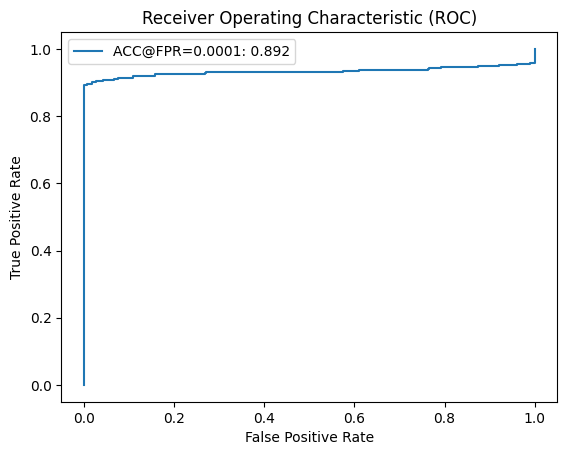

In [ ]:
#@title Insightface antelopev2 (ResNet100)

ver_acc_fpr = 1e-4

fpr, tpr, _ = roc_valid.compute()

acc_ver = np.interp(ver_acc_fpr, fpr.cpu(), tpr.cpu())

plt.plot(fpr, tpr, label=f'ACC@FPR={ver_acc_fpr}: {round(acc_ver, 4)}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='best')
plt.show()

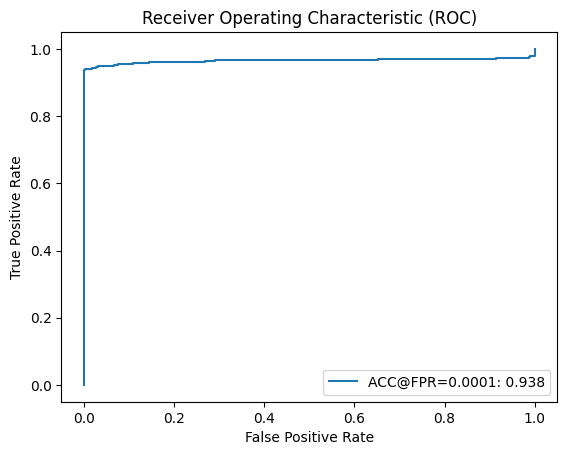

In [ ]:
#@title Insightface buffalo_l (ResNet50)

ver_acc_fpr = 1e-4

fpr, tpr, _ = roc_valid.compute()

acc_ver = np.interp(ver_acc_fpr, fpr.cpu(), tpr.cpu())

plt.plot(fpr, tpr, label=f'ACC@FPR={ver_acc_fpr}: {round(acc_ver, 4)}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='best')
plt.show()

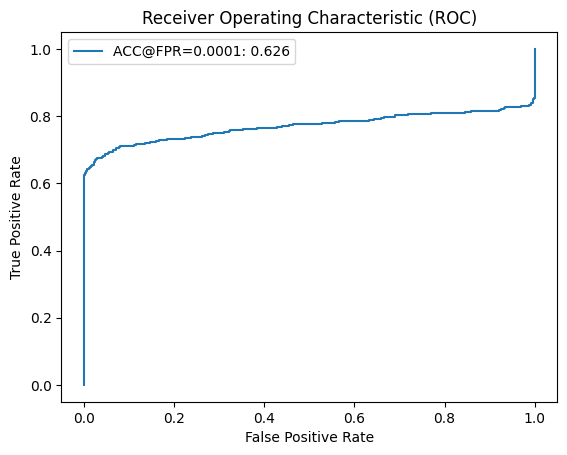

In [ ]:
#@title Insightface buffalo_s (MobileFaceNet)
ver_acc_fpr = 1e-4

fpr, tpr, _ = roc_valid.compute()

acc_ver = np.interp(ver_acc_fpr, fpr.cpu(), tpr.cpu())

plt.plot(fpr, tpr, label=f'ACC@FPR={ver_acc_fpr}: {round(acc_ver, 4)}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='best')
plt.show()

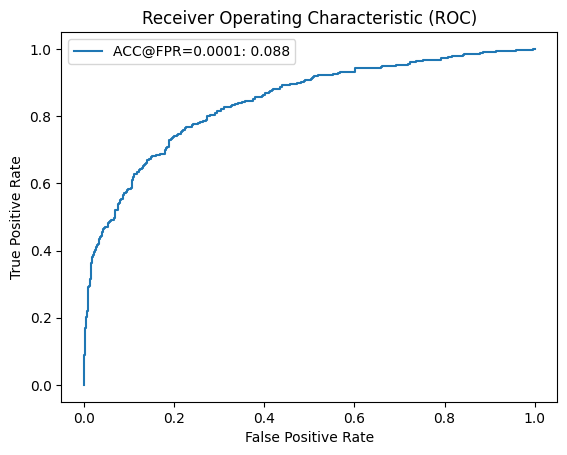

In [ ]:
#@title Best contrastive model
ver_acc_fpr = 1e-4

fpr, tpr, _ = roc_valid.compute()
acc_ver = np.interp(ver_acc_fpr, fpr.cpu(), tpr.cpu())

plt.plot(fpr, tpr, label=f'ACC@FPR={ver_acc_fpr}: {round(acc_ver, 4)}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='best')
plt.show()

# Wandb reports drafts

## Softmax loss

При обучении нейросетей для распознавания лиц в качестве оптимизатора чаще всего используется SGD. По сравнению с Adam с ним можно достичь более высоких резльтатов, однако для этого необходимо тщательно подбирать гиперпараметры. Чтобы примерно оценить пространство оптимальных гиперпараметров для SGD классификационная модель сначала была обучена на Cifar-10. В качестве классификационной модели была использована MobileFaceNet минимальной конфигурации с количеством блоков для каждого Residual Layer [1, 1, 1, 1] и параметром scale=2, контролирующим максимальное количество каналов во внутренних слоях модели в имплементации Insightface [[2]](https://github.com/deepinsight/insightface/blob/253c82a0a4cd961522438324cfd74d70f179fc5f/recognition/arcface_torch/backbones/mobilefacenet.py#L88).

В качестве начальных параметров для обучения были выбраны параметры, используемые в статьях, в которых модель была обучена с помощью ArcFace: в статье, впервые представившей MobileFaceNet [2] а также в статье ArcFace [3]:
- learning rate 0.1
- weight decay 4e-4
- momentum не использовался

Milestones для снижения learning rate определялись автоматически с помощью шедулера ReduceLROnPlateau.


Лучшимими параметрами оказались learning rate = 0.5, что выше, чем learning rate = 0.1, используемый в вышеупомянутых статьях. Это можно объяснить тем, что при меньшем наборе данных SGD требуется больший learning rate чтобы достичь того же эффектра регуляризации в начале обучения (т.е. избежать субоптимального локального минимума за счет исследования большего количества локальных минимумов в начале обучения). Набор данных Cifar-10 гораздо меньше по объему, чем самые маленькие наборы данных, использованные в вышеупомянутых статьях - 60 000 в Cifar-10 против 0.5 M в IBUG-500k и CASIA-WebFace, что подтверждает этот тезис.

На наборе данных CelebA-500, который ещё меньше чем Cifar-10 (16k против 60k) лучшим оказался learning rate = 1, что в 10 раз больше рекомендуемого в статьях.

In [ ]:
!pip install umap-learn

In [ ]:
from importlib import reload
reload(umap)

<module 'umap' from '/usr/local/lib/python3.10/dist-packages/umap/__init__.py'>

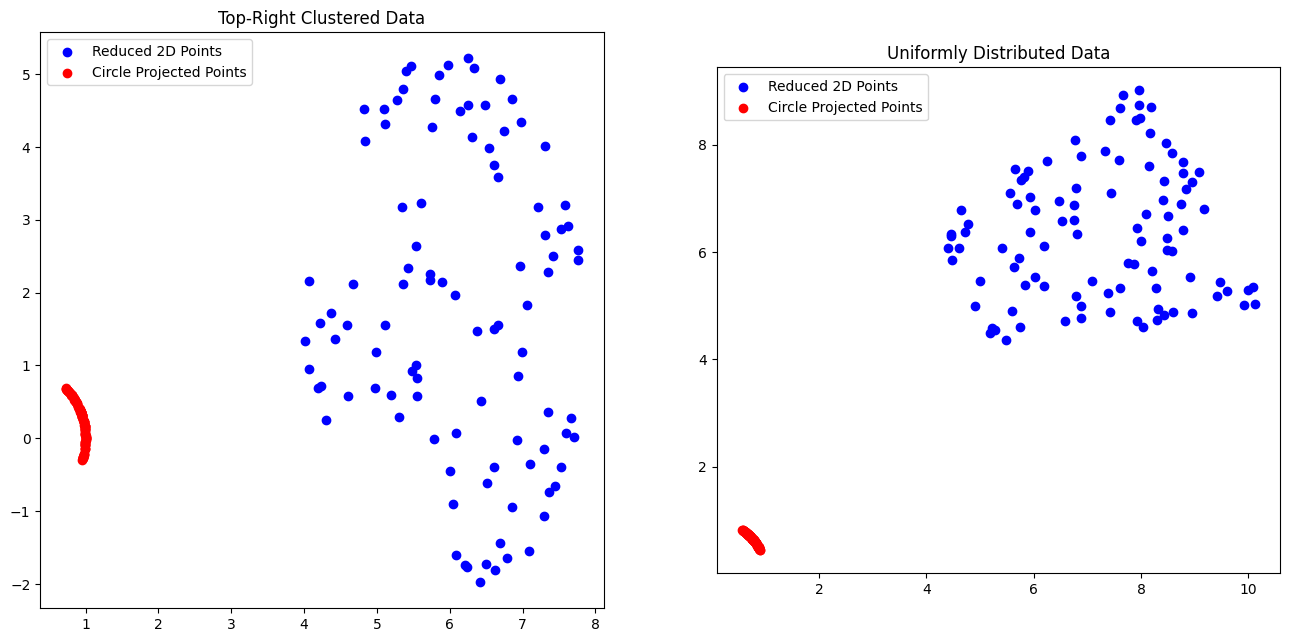

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import umap

# Generate synthetic datasets
# Dataset 1: Top-Right Clustered Data
np.random.seed(0)
data_topright = np.random.rand(100, 5) * [0.5, 0.5, 1, 1, 1] + [0.5, 0.5, 0, 0, 0]

# Dataset 2: Uniformly Distributed Data
data_uniform = np.random.rand(100, 5)

# Function to project onto a circle
def project_onto_circle(data):
    # Step 1: Normalize the embeddings
    norms = np.linalg.norm(data, axis=1, keepdims=True)
    normalized_data = data / norms

    # Step 2: Reduce dimensionality to 2D using UMAP
    reducer = umap.UMAP(n_components=2)
    reduced_data = reducer.fit_transform(normalized_data)

    # Step 3: Map the 2D points to the circumference of a circle
    angles = np.arctan2(reduced_data[:, 1], reduced_data[:, 0])
    radius = 1
    circle_data = np.column_stack((radius * np.cos(angles), radius * np.sin(angles)))

    return reduced_data, circle_data

# Project both datasets onto a circle
reduced_topright, circle_topright = project_onto_circle(data_topright)
reduced_uniform, circle_uniform = project_onto_circle(data_uniform)

# Plot the original reduced points and the circular projected points
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top-Right Clustered Data
axes[0].scatter(reduced_topright[:, 0], reduced_topright[:, 1], color='blue', label='Reduced 2D Points')
axes[0].scatter(circle_topright[:, 0], circle_topright[:, 1], color='red', label='Circle Projected Points')
axes[0].set_title('Top-Right Clustered Data')
axes[0].legend()
axes[0].set_aspect('equal', adjustable='box')

# Uniformly Distributed Data
axes[1].scatter(reduced_uniform[:, 0], reduced_uniform[:, 1], color='blue', label='Reduced 2D Points')
axes[1].scatter(circle_uniform[:, 0], circle_uniform[:, 1], color='red', label='Circle Projected Points')
axes[1].set_title('Uniformly Distributed Data')
axes[1].legend()
axes[1].set_aspect('equal', adjustable='box')

plt.show()
